# Hyperparameter tuning

Each model of interest will be tuned so that the selection of hyperparameters can be optimized


In [3]:
# IMPORT MODULES
%matplotlib notebook
import argparse
import gc
import os
import pickle
import subprocess
from datetime import datetime
import numpy as np
import torch
import pandas as pd
from scipy.stats import loguniform
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torch.autograd import Variable
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
from classes import model_classes, dataset_classes, train_functions
from classes.read_config import get_penalty_weights, balance_dataset, get_sample_subsets, get_case_control_count
from config_files.input_filenames import *
from config_files.input_variables import *

# SET USER INPUTS (DO NOT CHANGE)
testing_only = True
prevalent_prs = False


In [13]:
# USER INPUTS

experiment = "37b"
gpu_number = 0

disease_data_filename = "{}/config_files/disease_filenames_datadrive.txt".format(project_dir)

num_selections = 3

pd.set_option('display.max_columns', 15)

# To avoid issues with model being too large
pct_inputnodes_per_hiddenlayer = [0.1, 0.2, 0.3]
num_hidden_layers = [1]
max_epochs = 50

# Now create a dataframe with all combinations of the two
# All parameters will be copied across
# Include L1 (input and hidden), LR, dropout (input and hidden) (5 parameters; 10x random selections each)
hidden_dim = np.random.choice(pct_inputnodes_per_hiddenlayer, num_selections)
hidden_layers = np.random.choice(num_hidden_layers, num_selections)
# input_dropout = loguniform.rvs(0.000001, 0.8, size=num_selections)
# hidden_dropout = loguniform.rvs(0.1, 0.8, size=num_selections)
input_dropout = np.random.uniform(0, 0.8, size=num_selections)
hidden_dropout = np.random.uniform(0.1, 0.5, size=num_selections)
input_l1 = loguniform.rvs(1e-5, 0.05, size=num_selections)
hidden_l1 = loguniform.rvs(1e-6, 0.01, size=num_selections)
# hidden_l1 = np.random.uniform(0, 0.01, size=num_selections)
lr = loguniform.rvs(1e-5, 1e-3, size=num_selections)

hidden_dim = [0.1] * num_selections
hidden_layers = [1] * num_selections
input_dropout = [0.1] * num_selections
hidden_dropout = [0.4] * num_selections
input_l1 = [0.1] * num_selections
hidden_l1 = [5e-5, 5e-2, 5e-3]
lr = [1e-4] * num_selections

combinations_all = pd.DataFrame({"Hidden_Layers": hidden_layers,
                                  "Hidden_Dim": hidden_dim,
                                  "L1_input": input_l1,
                                  "L1_hidden": hidden_l1,
                                  "Dropout_input": input_dropout,
                                  "Dropout_hidden": hidden_dropout,
                                  "LR": lr,
                                  "Best AUC": [np.nan] * num_selections,
                                  "Best Loss": [np.nan] * num_selections,
                                  "Best AUC Epoch": [np.nan] * num_selections,
                                  "Loss at Best AUC Epoch": [np.nan] * num_selections,
                                  "Best Loss Epoch": [np.nan] * num_selections,
                                  "AUC at Best Loss Epoch": [np.nan] * num_selections,
                                  "Total Epochs": [max_epochs] * num_selections,
                                  "Status": ["Not Started"] * num_selections})
print(combinations_all)

   Hidden_Layers  Hidden_Dim  L1_input  L1_hidden  Dropout_input  \
0              1         0.1       0.1    0.00005            0.1   
1              1         0.1       0.1    0.05000            0.1   
2              1         0.1       0.1    0.00500            0.1   

   Dropout_hidden      LR  Best AUC  Best Loss  Best AUC Epoch  \
0             0.4  0.0001       NaN        NaN             NaN   
1             0.4  0.0001       NaN        NaN             NaN   
2             0.4  0.0001       NaN        NaN             NaN   

   Loss at Best AUC Epoch  Best Loss Epoch  AUC at Best Loss Epoch  \
0                     NaN              NaN                     NaN   
1                     NaN              NaN                     NaN   
2                     NaN              NaN                     NaN   

   Total Epochs       Status  
0            50  Not Started  
1            50  Not Started  
2            50  Not Started  


Disease Name: Breast_Cancer
PRS Set: None
PRS Names: ['BC_77', 'BC_313']
NG Set: NG2
M: M2

-------------------------

         UKB ID  time_window_incident/nan/10.0/nan/av1
0       5713894                                    0.0
1       2048882                                    1.0
2       1748132                                    0.0
3       3772083                                    0.0
4       4376107                                    0.0
...         ...                                    ...
471726  2637602                                    0.0
471727  2397350                                    0.0
471728  3905086                                    0.0
471729  5844444                                    0.0
471730  3002154                                    0.0

[471731 rows x 2 columns]

-----------
Starting trial 1
------------

Train Class Penalty: {'case_weight': 37.0, 'control_weight': 1}


---------------
Running Experiment 37b

Loading data...
         UKB ID  time_window

<IPython.core.display.Javascript object>


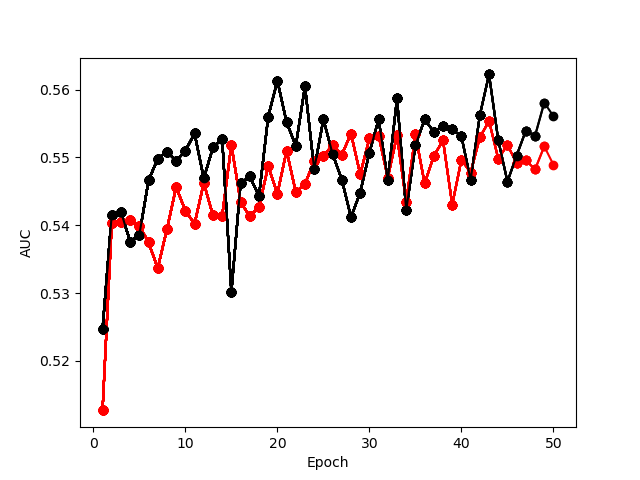


---------
Epoch 1 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 22.199901353426238
Train AUC: 0.5126800710768779
Train Accuracy: 0.43632737479686806



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 3.2736169163458815
Validation AUC: 0.5246539766325011
Validation Accuracy: 0.4608069238941722
Best Val AUC: 0.5246539766325011 at epoch 1
Best Val Loss: 3.2736169163458815 at epoch 1
Epoch Time: 4.370384454727173

---------
Epoch 2 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 2.6556399243199884
Train AUC: 0.5402819258528455
Train Accuracy: 0.45571724036046685



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 2.2836286791725335
Validation AUC: 0.5415681510332535
Validation Accuracy: 0.4410613873701122
If converges, will stop in 9 iterations
Best Val AUC: 0.5415681510332535 at epoch 2
Best Val Loss: 2.2836286791725335 at epoch 2
Epoch Time: 4.192620038986206

---------
Epoch 3 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 2.1450726175679113
Train AUC: 0.5405399167853121
Train Accuracy: 0.4493573644556064



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 2.0933062906582633
Validation AUC: 0.5419935263840613
Validation Accuracy: 0.45046772563551085
If converges, will stop in 9 iterations
Best Val AUC: 0.5419935263840613 at epoch 3
Best Val Loss: 2.0933062906582633 at epoch 3
Epoch Time: 4.189966440200806

---------
Epoch 4 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.9658484216113437
Train AUC: 0.5407569450908721
Train Accuracy: 0.440013295907815



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.906625883097292
Validation AUC: 0.5375669086148307
Validation Accuracy: 0.4349459718587235
If converges, will stop in 9 iterations
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.5419935263840613 at epoch 3
Best Val Loss: 1.906625883097292 at epoch 4
Epoch Time: 4.203298807144165

---------
Epoch 5 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.8574400507292987
Train AUC: 0.5399217912711286
Train Accuracy: 0.4311789038262668



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.8322788786044226
Validation AUC: 0.5385962402267831
Validation Accuracy: 0.43124044466326344
If converges, will stop in 8 iterations
Best Val AUC: 0.5419935263840613 at epoch 3
Best Val Loss: 1.8322788786044226 at epoch 5
Epoch Time: 4.247088193893433

---------
Epoch 6 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.7791781903034773
Train AUC: 0.5374579339587635
Train Accuracy: 0.42673216132368147



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.7291625989110726
Validation AUC: 0.546612617551174
Validation Accuracy: 0.4223523619496774
If converges, will stop in 9 iterations
Best Val AUC: 0.546612617551174 at epoch 6
Best Val Loss: 1.7291625989110726 at epoch 6
Epoch Time: 4.231273412704468

---------
Epoch 7 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.7101152003881936
Train AUC: 0.5336566084918699
Train Accuracy: 0.41622100753434776



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.680974615504633
Validation AUC: 0.5498256061489308
Validation Accuracy: 0.4150708714467104
If converges, will stop in 9 iterations
Best Val AUC: 0.5498256061489308 at epoch 7
Best Val Loss: 1.680974615504633 at epoch 7
Epoch Time: 4.217238664627075

---------
Epoch 8 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.6533798605628225
Train AUC: 0.5394330014390912
Train Accuracy: 0.40262224848574385



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.624478003755621
Validation AUC: 0.5508599848925957
Validation Accuracy: 0.39439247492938767
If converges, will stop in 9 iterations
Best Val AUC: 0.5508599848925957 at epoch 8
Best Val Loss: 1.624478003755621 at epoch 8
Epoch Time: 4.25783109664917

---------
Epoch 9 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.6291303179410859
Train AUC: 0.5456279030776333
Train Accuracy: 0.397163539666125



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.6165920018937168
Validation AUC: 0.5494911692962996
Validation Accuracy: 0.40296960431188616
If converges, will stop in 9 iterations
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.5508599848925957 at epoch 8
Best Val Loss: 1.6165920018937168 at epoch 9
Epoch Time: 4.153716325759888

---------
Epoch 10 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.6001460495485103
Train AUC: 0.5421344472458745
Train Accuracy: 0.40105628600975035



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5725465849517455
Validation AUC: 0.5509735839821344
Validation Accuracy: 0.4079966831644684
If converges, will stop in 8 iterations
Best Val AUC: 0.5509735839821344 at epoch 10
Best Val Loss: 1.5725465849517455 at epoch 10
Epoch Time: 4.173482179641724

---------
Epoch 11 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5874913192472804
Train AUC: 0.5402086621701545
Train Accuracy: 0.4142266213620919



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.549113976016046
Validation AUC: 0.5535562733812883
Validation Accuracy: 0.4086963281594154
If converges, will stop in 9 iterations
Best Val AUC: 0.5535562733812883 at epoch 11
Best Val Loss: 1.549113976016046 at epoch 11
Epoch Time: 4.169518709182739

---------
Epoch 12 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.584399750054667
Train AUC: 0.5462288158751396
Train Accuracy: 0.4181341409366228



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.612283744692838
Validation AUC: 0.5469033168874091
Validation Accuracy: 0.4465808089969164
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.5535562733812883 at epoch 11
Best Val Loss: 1.549113976016046 at epoch 11
Epoch Time: 4.390847682952881

---------
Epoch 13 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.6131414120023104
Train AUC: 0.541444415757635
Train Accuracy: 0.4561973703648988



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.6013816500345048
Validation AUC: 0.5514779366439737
Validation Accuracy: 0.4743852193516623
If converges, will stop in 9 iterations
Best Val AUC: 0.5535562733812883 at epoch 11
Best Val Loss: 1.549113976016046 at epoch 11
Epoch Time: 4.232258558273315

---------
Epoch 14 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5810518296960423
Train AUC: 0.5413834839815705
Train Accuracy: 0.49229576008273007



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5502757776903442
Validation AUC: 0.5527468010068924
Validation Accuracy: 0.5109740613096317
If converges, will stop in 9 iterations
Best Val AUC: 0.5535562733812883 at epoch 11
Best Val Loss: 1.549113976016046 at epoch 11
Epoch Time: 4.225245475769043

---------
Epoch 15 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5604360230851737
Train AUC: 0.5518525144519933
Train Accuracy: 0.5185773378637908



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5596432079837634
Validation AUC: 0.5301430542532153
Validation Accuracy: 0.5203803995750305
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.5535562733812883 at epoch 11
Best Val Loss: 1.549113976016046 at epoch 11
Epoch Time: 4.21018648147583

---------
Epoch 16 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5762596156289854
Train AUC: 0.5434361827386726
Train Accuracy: 0.5342517358546314



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5663740631482383
Validation AUC: 0.5461709806509966
Validation Accuracy: 0.5304345572801948
Best Val AUC: 0.5535562733812883 at epoch 11
Best Val Loss: 1.549113976016046 at epoch 11
Epoch Time: 4.251941204071045

---------
Epoch 17 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.548027480030719
Train AUC: 0.5413086638242243
Train Accuracy: 0.5485300635248929



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.538999073476012
Validation AUC: 0.547201496793861
Validation Accuracy: 0.5564768987587779
If converges, will stop in 9 iterations
Best Val AUC: 0.5535562733812883 at epoch 11
Best Val Loss: 1.538999073476012 at epoch 17
Epoch Time: 4.41298770904541

---------
Epoch 18 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5331642408897945
Train AUC: 0.5426858357541983
Train Accuracy: 0.550110799231792



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5200797753393105
Validation AUC: 0.5442882846442202
Validation Accuracy: 0.5756005286206628
If converges, will stop in 9 iterations
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.5535562733812883 at epoch 11
Best Val Loss: 1.5200797753393105 at epoch 18
Epoch Time: 4.275562524795532

---------
Epoch 19 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5351380423919059
Train AUC: 0.5486909842021692
Train Accuracy: 0.5486556359875905



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.526760913936609
Validation AUC: 0.5560004627910773
Validation Accuracy: 0.5568396776450468
Best Val AUC: 0.5560004627910773 at epoch 19
Best Val Loss: 1.5200797753393105 at epoch 18
Epoch Time: 4.277261972427368

---------
Epoch 20 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5363234444158298
Train AUC: 0.544642175058404
Train Accuracy: 0.5681784606293396



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5305696250702656
Validation AUC: 0.5613168821560152
Validation Accuracy: 0.5367054494571273
Best Val AUC: 0.5613168821560152 at epoch 20
Best Val Loss: 1.5200797753393105 at epoch 18
Epoch Time: 4.185640811920166

---------
Epoch 21 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5519968241783322
Train AUC: 0.5509891505807956
Train Accuracy: 0.5570616043728763



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5348664622833201
Validation AUC: 0.5551987156182823
Validation Accuracy: 0.5558809048741935
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.5613168821560152 at epoch 20
Best Val Loss: 1.5200797753393105 at epoch 18
Epoch Time: 4.1964991092681885

---------
Epoch 22 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5391495577732965
Train AUC: 0.544897117193556
Train Accuracy: 0.5516693750923327



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5815531842804542
Validation AUC: 0.5517046584356189
Validation Accuracy: 0.5712212692078464
If performance continues to decrease, will stop in 2 iterations
Best Val AUC: 0.5613168821560152 at epoch 20
Best Val Loss: 1.5200797753393105 at epoch 18
Epoch Time: 4.2844390869140625

---------
Epoch 23 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5509094116429216
Train AUC: 0.546076022647598
Train Accuracy: 0.553648988033683



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5317155227578239
Validation AUC: 0.56051513498322
Validation Accuracy: 0.5534710165582649
If converges, will stop in 9 iterations
Best Val AUC: 0.5613168821560152 at epoch 20
Best Val Loss: 1.5200797753393105 at epoch 18
Epoch Time: 4.272343873977661

---------
Epoch 24 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5207057760257934
Train AUC: 0.5495011471386477
Train Accuracy: 0.5612054956418969



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5180905556395181
Validation AUC: 0.548224274859789
Validation Accuracy: 0.5498432276955767
If converges, will stop in 9 iterations
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.5613168821560152 at epoch 20
Best Val Loss: 1.5180905556395181 at epoch 24
Epoch Time: 4.2815635204315186

---------
Epoch 25 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5338970554126647
Train AUC: 0.5501532542805745
Train Accuracy: 0.5584576746934554



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5305762826082256
Validation AUC: 0.5556223527987297
Validation Accuracy: 0.5613225881682258
Best Val AUC: 0.5613168821560152 at epoch 20
Best Val Loss: 1.5180905556395181 at epoch 24
Epoch Time: 4.276487112045288

---------
Epoch 26 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5371403781610606
Train AUC: 0.5518859723470486
Train Accuracy: 0.5664130595361205



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5708010809822346
Validation AUC: 0.5505155567792275
Validation Accuracy: 0.5650540281412765
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.5613168821560152 at epoch 20
Best Val Loss: 1.5180905556395181 at epoch 24
Epoch Time: 4.254591941833496

---------
Epoch 27 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.571701578545013
Train AUC: 0.5504097970606086
Train Accuracy: 0.5529620327965726



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.6008790528601784
Validation AUC: 0.5467269762855366
Validation Accuracy: 0.5516312093493302
If performance continues to decrease, will stop in 2 iterations
Best Val AUC: 0.5613168821560152 at epoch 20
Best Val Loss: 1.5180905556395181 at epoch 24
Epoch Time: 4.26929783821106

---------
Epoch 28 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.582793626077703
Train AUC: 0.5535108582700765
Train Accuracy: 0.5610134436401241



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5970757729184262
Validation AUC: 0.5411851870392336
Validation Accuracy: 0.5631105698219793
If converges, will stop in 9 iterations
If performance continues to decrease, will stop in 1 iterations
Best Val AUC: 0.5613168821560152 at epoch 20
Best Val Loss: 1.5180905556395181 at epoch 24
Epoch Time: 4.417291641235352

---------
Epoch 29 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.570794596997219
Train AUC: 0.5475211725564677
Train Accuracy: 0.5638277441276407



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5541114083551977
Validation AUC: 0.5448196368856539
Validation Accuracy: 0.5639916042600607
If converges, will stop in 8 iterations
Best Val AUC: 0.5613168821560152 at epoch 20
Best Val Loss: 1.5180905556395181 at epoch 24
Epoch Time: 4.2578675746917725

---------
Epoch 30 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5482939906521025
Train AUC: 0.5528083202976478
Train Accuracy: 0.5723592849756242



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5578730709283426
Validation AUC: 0.5507056353646133
Validation Accuracy: 0.5679303464538363
Best Val AUC: 0.5613168821560152 at epoch 20
Best Val Loss: 1.5180905556395181 at epoch 24
Epoch Time: 4.305915117263794

---------
Epoch 31 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.529428622718059
Train AUC: 0.55321652365441
Train Accuracy: 0.5640197961294136



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.530064446107754
Validation AUC: 0.555624129595098
Validation Accuracy: 0.5559068176517841
If converges, will stop in 9 iterations
Best Val AUC: 0.5613168821560152 at epoch 20
Best Val Loss: 1.5180905556395181 at epoch 24
Epoch Time: 4.429004907608032

---------
Epoch 32 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5456706469739838
Train AUC: 0.5470195523252452
Train Accuracy: 0.5605480868665977



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5486115329083927
Validation AUC: 0.5466330378340718
Validation Accuracy: 0.5380270011142494
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.5613168821560152 at epoch 20
Best Val Loss: 1.5180905556395181 at epoch 24
Epoch Time: 4.296061038970947

---------
Epoch 33 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5552619980637215
Train AUC: 0.5532627446416383
Train Accuracy: 0.5405894519131335



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5343135170614384
Validation AUC: 0.5587281799749487
Validation Accuracy: 0.5492731465885828
If converges, will stop in 9 iterations
Best Val AUC: 0.5613168821560152 at epoch 20
Best Val Loss: 1.5180905556395181 at epoch 24
Epoch Time: 4.316155195236206

---------
Epoch 34 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5352146645857454
Train AUC: 0.5433920303903949
Train Accuracy: 0.5490988329147585



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.561728203580479
Validation AUC: 0.5421917808078078
Validation Accuracy: 0.5444792827343163
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.5613168821560152 at epoch 20
Best Val Loss: 1.5180905556395181 at epoch 24
Epoch Time: 4.275770664215088

---------
Epoch 35 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5563376991626523
Train AUC: 0.5533938260994112
Train Accuracy: 0.5607770719456345



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5360233090155615
Validation AUC: 0.5518110344616608
Validation Accuracy: 0.5508797387992019
If converges, will stop in 9 iterations
Best Val AUC: 0.5613168821560152 at epoch 20
Best Val Loss: 1.5180905556395181 at epoch 24
Epoch Time: 4.300375938415527

---------
Epoch 36 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5205389214927985
Train AUC: 0.5461662866092094
Train Accuracy: 0.5553257497414684



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.4980862842085723
Validation AUC: 0.5556049839704642
Validation Accuracy: 0.5419657433080252
If converges, will stop in 9 iterations
Best Val AUC: 0.5613168821560152 at epoch 20
Best Val Loss: 1.4980862842085723 at epoch 36
Epoch Time: 4.448954105377197

---------
Epoch 37 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5197116647711286
Train AUC: 0.5502210766120047
Train Accuracy: 0.545944748116413



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.523137156030819
Validation AUC: 0.5537939005825265
Validation Accuracy: 0.5376901350055713
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.5613168821560152 at epoch 20
Best Val Loss: 1.4980862842085723 at epoch 36
Epoch Time: 4.255996227264404

---------
Epoch 38 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5332408227355419
Train AUC: 0.552514605116827
Train Accuracy: 0.5464839710444674



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5153917933736871
Validation AUC: 0.5546231623483562
Validation Accuracy: 0.5200694462439429
If converges, will stop in 9 iterations
Best Val AUC: 0.5613168821560152 at epoch 20
Best Val Loss: 1.4980862842085723 at epoch 36
Epoch Time: 4.230919122695923

---------
Epoch 39 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5290107163340905
Train AUC: 0.5430310818145001
Train Accuracy: 0.5327374796868075



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5576111087806412
Validation AUC: 0.554161478550025
Validation Accuracy: 0.5170635640434298
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.5613168821560152 at epoch 20
Best Val Loss: 1.4980862842085723 at epoch 36
Epoch Time: 4.2857019901275635

---------
Epoch 40 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.546684790248168
Train AUC: 0.5496699836235309
Train Accuracy: 0.517173880927759



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.549037543224328
Validation AUC: 0.5531062546373742
Validation Accuracy: 0.5206654401285273
If converges, will stop in 9 iterations
If performance continues to decrease, will stop in 2 iterations
Best Val AUC: 0.5613168821560152 at epoch 20
Best Val Loss: 1.4980862842085723 at epoch 36
Epoch Time: 4.3085105419158936

---------
Epoch 41 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5275292303072796
Train AUC: 0.5477704935044359
Train Accuracy: 0.5194785049490324



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5205474555621052
Validation AUC: 0.5466690372735312
Validation Accuracy: 0.5264699023088285
If converges, will stop in 8 iterations
If performance continues to decrease, will stop in 1 iterations
Best Val AUC: 0.5613168821560152 at epoch 20
Best Val Loss: 1.4980862842085723 at epoch 36
Epoch Time: 4.299978733062744

---------
Epoch 42 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5210199315787782
Train AUC: 0.5529566891408145
Train Accuracy: 0.5239991136061457



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5175793279707002
Validation AUC: 0.5562366350793474
Validation Accuracy: 0.5101707652043223
If converges, will stop in 7 iterations
Best Val AUC: 0.5613168821560152 at epoch 20
Best Val Loss: 1.4980862842085723 at epoch 36
Epoch Time: 4.209763765335083

---------
Epoch 43 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5316621421725212
Train AUC: 0.5553762784209748
Train Accuracy: 0.5264440833210223



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5333012472744743
Validation AUC: 0.5622518504304147
Validation Accuracy: 0.5113627529734912
Best Val AUC: 0.5622518504304147 at epoch 43
Best Val Loss: 1.4980862842085723 at epoch 36
Epoch Time: 4.303626775741577

---------
Epoch 44 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.532505322810824
Train AUC: 0.5498124546897607
Train Accuracy: 0.518791549711922



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5113490521478614
Validation AUC: 0.55257046040502
Validation Accuracy: 0.4746961726827499
If converges, will stop in 9 iterations
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.5622518504304147 at epoch 43
Best Val Loss: 1.4980862842085723 at epoch 36
Epoch Time: 4.309554815292358

---------
Epoch 45 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5276471548673467
Train AUC: 0.5518411553420263
Train Accuracy: 0.49395774855961



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.545968229051022
Validation AUC: 0.5464310495628849
Validation Accuracy: 0.4799305537560571
If performance continues to decrease, will stop in 2 iterations
Best Val AUC: 0.5622518504304147 at epoch 43
Best Val Loss: 1.4980862842085723 at epoch 36
Epoch Time: 4.301429033279419

---------
Epoch 46 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5291231380851207
Train AUC: 0.5491563711757586
Train Accuracy: 0.48535972817255135



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.531914606010781
Validation AUC: 0.5502838908585578
Validation Accuracy: 0.47415200435334665
If converges, will stop in 8 iterations
Best Val AUC: 0.5622518504304147 at epoch 43
Best Val Loss: 1.4980862842085723 at epoch 36
Epoch Time: 4.295729637145996

---------
Epoch 47 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5336670830714159
Train AUC: 0.5495781337404465
Train Accuracy: 0.4747673216132368



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5203016209191085
Validation AUC: 0.5539610224438223
Validation Accuracy: 0.44880930786971057
If converges, will stop in 9 iterations
Best Val AUC: 0.5622518504304147 at epoch 43
Best Val Loss: 1.4980862842085723 at epoch 36
Epoch Time: 4.321126699447632

---------
Epoch 48 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5282410332798761
Train AUC: 0.5482322406410104
Train Accuracy: 0.47734525040626385



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5270244968063083
Validation AUC: 0.5531893778065979
Validation Accuracy: 0.4231297452773963
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.5622518504304147 at epoch 43
Best Val Loss: 1.4980862842085723 at epoch 36
Epoch Time: 4.295672655105591

---------
Epoch 49 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5187404274727698
Train AUC: 0.5516350938727533
Train Accuracy: 0.4583099423843995



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5158947796925057
Validation AUC: 0.5580879023909447
Validation Accuracy: 0.489673758130134
If converges, will stop in 9 iterations
Best Val AUC: 0.5622518504304147 at epoch 43
Best Val Loss: 1.4980862842085723 at epoch 36
Epoch Time: 4.370320796966553

---------
Epoch 50 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5378213854839975
Train AUC: 0.5489205368703437
Train Accuracy: 0.4842000295464618



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5707733383320648
Validation AUC: 0.5560910279045097
Validation Accuracy: 0.4983286258454044
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.5622518504304147 at epoch 43
Best Val Loss: 1.4980862842085723 at epoch 36
Epoch Time: 4.336453437805176


<IPython.core.display.Javascript object>

/home/monica/anaconda3/envs/myenv/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


   Hidden_Layers  Hidden_Dim  L1_input  L1_hidden  Dropout_input  \
0              1         0.1       0.1    0.00005            0.1   
1              1         0.1       0.1    0.05000            0.1   
2              1         0.1       0.1    0.00500            0.1   

   Dropout_hidden      LR  Best AUC  Best Loss  Best AUC Epoch  \
0             0.4  0.0001  0.562252   1.498086            43.0   
1             0.4  0.0001       NaN        NaN             NaN   
2             0.4  0.0001       NaN        NaN             NaN   

   Loss at Best AUC Epoch  Best Loss Epoch  AUC at Best Loss Epoch  \
0                1.533301             36.0                0.555605   
1                     NaN              NaN                     NaN   
2                     NaN              NaN                     NaN   

   Total Epochs       Status  
0            50         Done  
1            50  Not Started  
2            50  Not Started  
setting up model...
Penalizing the classes
done setting u

<IPython.core.display.Javascript object>


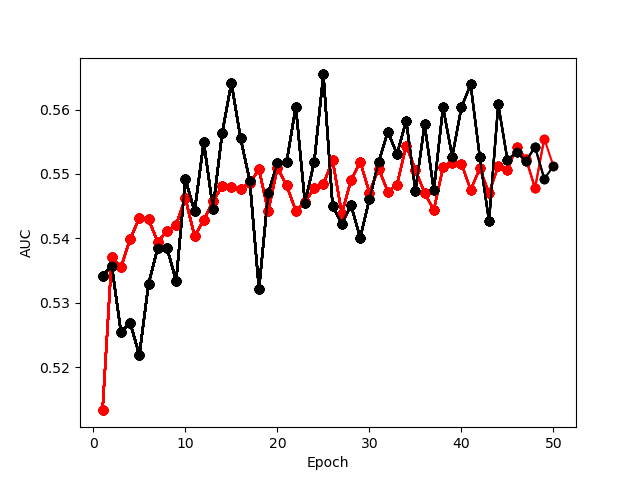


---------
Epoch 1 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 22.36321126307286
Train AUC: 0.5132700475365869
Train Accuracy: 0.44971192199734084



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 3.349968219570228
Validation AUC: 0.5342152526483407
Validation Accuracy: 0.4533440439480708
Best Val AUC: 0.5342152526483407 at epoch 1
Best Val Loss: 3.349968219570228 at epoch 1
Epoch Time: 4.290172100067139

---------
Epoch 2 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 2.7072701388516
Train AUC: 0.5371081289000628
Train Accuracy: 0.4483897178312897



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 2.3799814899728213
Validation AUC: 0.5357604732231894
Validation Accuracy: 0.4465808089969164
If converges, will stop in 9 iterations
Best Val AUC: 0.5357604732231894 at epoch 2
Best Val Loss: 2.3799814899728213 at epoch 2
Epoch Time: 4.291481018066406

---------
Epoch 3 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 2.1646539358217036
Train AUC: 0.5354972049753612
Train Accuracy: 0.4382109617373319



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 2.07892921695572
Validation AUC: 0.5254263036625335
Validation Accuracy: 0.43966209738021816
If converges, will stop in 9 iterations
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.5357604732231894 at epoch 2
Best Val Loss: 2.07892921695572 at epoch 3
Epoch Time: 4.213916778564453

---------
Epoch 4 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.9501654894926417
Train AUC: 0.5398739549156094
Train Accuracy: 0.43494607770719457



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.8903395235166809
Validation AUC: 0.5268956627576631
Validation Accuracy: 0.4369930812883833
If converges, will stop in 8 iterations
Best Val AUC: 0.5357604732231894 at epoch 2
Best Val Loss: 1.8903395235166809 at epoch 4
Epoch Time: 4.243322849273682

---------
Epoch 5 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.8189649724338448
Train AUC: 0.5431661764528706
Train Accuracy: 0.4300044319692717



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.8086074836890473
Validation AUC: 0.5218570545176232
Validation Accuracy: 0.4178435386489078
If converges, will stop in 9 iterations
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.5357604732231894 at epoch 2
Best Val Loss: 1.8086074836890473 at epoch 5
Epoch Time: 4.261297225952148

---------
Epoch 6 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.7645358838211163
Train AUC: 0.5429285458915698
Train Accuracy: 0.42601565962475996



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.7188777767888155
Validation AUC: 0.5329604352769992
Validation Accuracy: 0.4390661034956337
If converges, will stop in 8 iterations
Best Val AUC: 0.5357604732231894 at epoch 2
Best Val Loss: 1.7188777767888155 at epoch 6
Epoch Time: 4.2655274868011475

---------
Epoch 7 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.6837131418176372
Train AUC: 0.5394318246180513
Train Accuracy: 0.43187324567882995



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.6562532234121539
Validation AUC: 0.5384978082830538
Validation Accuracy: 0.4352569251898111
If converges, will stop in 9 iterations
Best Val AUC: 0.5384978082830538 at epoch 7
Best Val Loss: 1.6562532234121539 at epoch 7
Epoch Time: 4.254267930984497

---------
Epoch 8 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.6338885403439078
Train AUC: 0.5411724849119554
Train Accuracy: 0.4395922588270055



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.6197451536699312
Validation AUC: 0.5385248078626483
Validation Accuracy: 0.4511155450752766
If converges, will stop in 9 iterations
Best Val AUC: 0.5385248078626483 at epoch 8
Best Val Loss: 1.6197451536699312 at epoch 8
Epoch Time: 4.229248523712158

---------
Epoch 9 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.603744505343698
Train AUC: 0.542093796965571
Train Accuracy: 0.4686216575565076



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.585378919023099
Validation AUC: 0.5333789480737184
Validation Accuracy: 0.4652898344173512
If converges, will stop in 9 iterations
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.5385248078626483 at epoch 8
Best Val Loss: 1.585378919023099 at epoch 9
Epoch Time: 4.2258360385894775

---------
Epoch 10 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.56864925207903
Train AUC: 0.5462440430349593
Train Accuracy: 0.48647510710592407



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5636839281010892
Validation AUC: 0.5491988347923922
Validation Accuracy: 0.4897255836853152
If converges, will stop in 8 iterations
Best Val AUC: 0.5491988347923922 at epoch 10
Best Val Loss: 1.5636839281010892 at epoch 10
Epoch Time: 4.2660813331604

---------
Epoch 11 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5782799667937464
Train AUC: 0.5403125652667683
Train Accuracy: 0.4971413798197666



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5626719153244633
Validation AUC: 0.544180170447818
Validation Accuracy: 0.49115078645279986
If converges, will stop in 9 iterations
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.5491988347923922 at epoch 10
Best Val Loss: 1.5626719153244633 at epoch 11
Epoch Time: 4.232274055480957

---------
Epoch 12 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.546690642608731
Train AUC: 0.5428279660786794
Train Accuracy: 0.5133106810459448



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.529300538295724
Validation AUC: 0.5549652213999003
Validation Accuracy: 0.5223497706719183
If converges, will stop in 8 iterations
Best Val AUC: 0.5549652213999003 at epoch 12
Best Val Loss: 1.529300538295724 at epoch 12
Epoch Time: 4.283480882644653

---------
Epoch 13 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.559015417087989
Train AUC: 0.5457946698718938
Train Accuracy: 0.5281430048751662



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5722947399972547
Validation AUC: 0.5446127044854426
Validation Accuracy: 0.5206395273509368
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.5549652213999003 at epoch 12
Best Val Loss: 1.529300538295724 at epoch 12
Epoch Time: 4.291522026062012

---------
Epoch 14 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5468353907548944
Train AUC: 0.5480582225678661
Train Accuracy: 0.5331437435367115



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5407851688566625
Validation AUC: 0.5563523070979821
Validation Accuracy: 0.5361612811277241
If converges, will stop in 9 iterations
Best Val AUC: 0.5563523070979821 at epoch 14
Best Val Loss: 1.529300538295724 at epoch 12
Epoch Time: 4.269739151000977

---------
Epoch 15 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5396929148044578
Train AUC: 0.5479341967779731
Train Accuracy: 0.5418525631555621



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.522533159320592
Validation AUC: 0.5641526105336008
Validation Accuracy: 0.5172967790417455
If converges, will stop in 9 iterations
Best Val AUC: 0.5641526105336008 at epoch 15
Best Val Loss: 1.522533159320592 at epoch 15
Epoch Time: 4.337762832641602

---------
Epoch 16 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5346185696433634
Train AUC: 0.5477068873263117
Train Accuracy: 0.5545944748116413



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5176416389990455
Validation AUC: 0.5555361910502097
Validation Accuracy: 0.5413697494234407
If converges, will stop in 9 iterations
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.5641526105336008 at epoch 15
Best Val Loss: 1.5176416389990455 at epoch 16
Epoch Time: 4.375552177429199

---------
Epoch 17 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5367479571814748
Train AUC: 0.5486066274825434
Train Accuracy: 0.5416088048456197



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.564416091876235
Validation AUC: 0.5489332423613593
Validation Accuracy: 0.5193438884714052
If performance continues to decrease, will stop in 2 iterations
Best Val AUC: 0.5641526105336008 at epoch 15
Best Val Loss: 1.5176416389990455 at epoch 16
Epoch Time: 4.332289934158325

---------
Epoch 18 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5667369449690796
Train AUC: 0.5507028686181258
Train Accuracy: 0.5353892746343626



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5999602438348008
Validation AUC: 0.5320550545247305
Validation Accuracy: 0.5432613821875567
If performance continues to decrease, will stop in 1 iterations
Best Val AUC: 0.5641526105336008 at epoch 15
Best Val Loss: 1.5176416389990455 at epoch 16
Epoch Time: 4.325282335281372

---------
Epoch 19 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5717643234519796
Train AUC: 0.5441865886167823
Train Accuracy: 0.5304106958191757



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5679293461297388
Validation AUC: 0.5469911395542735
Validation Accuracy: 0.5203544867974398
If converges, will stop in 8 iterations
Best Val AUC: 0.5641526105336008 at epoch 15
Best Val Loss: 1.5176416389990455 at epoch 16
Epoch Time: 4.547156810760498

---------
Epoch 20 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.560255695869636
Train AUC: 0.5509396021031557
Train Accuracy: 0.531356182597134



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.535080934041804
Validation AUC: 0.5516699465297596
Validation Accuracy: 0.5193698012489959
If converges, will stop in 9 iterations
Best Val AUC: 0.5641526105336008 at epoch 15
Best Val Loss: 1.5176416389990455 at epoch 16
Epoch Time: 4.339334011077881

---------
Epoch 21 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5226863868905216
Train AUC: 0.5482140687994105
Train Accuracy: 0.550110799231792



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5087538878509157
Validation AUC: 0.5518085495218126
Validation Accuracy: 0.475318079344925
If converges, will stop in 9 iterations
Best Val AUC: 0.5641526105336008 at epoch 15
Best Val Loss: 1.5087538878509157 at epoch 21
Epoch Time: 4.326542139053345

---------
Epoch 22 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.512773411543296
Train AUC: 0.5442941851856862
Train Accuracy: 0.5486039296794208



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5122546996134212
Validation AUC: 0.560459140146951
Validation Accuracy: 0.5413956622010313
Best Val AUC: 0.5641526105336008 at epoch 15
Best Val Loss: 1.5087538878509157 at epoch 21
Epoch Time: 4.296056747436523

---------
Epoch 23 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5458941439665974
Train AUC: 0.5456250961648935
Train Accuracy: 0.5515585758605407



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.532779350877827
Validation AUC: 0.5454973301960775
Validation Accuracy: 0.5346324272498769
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.5641526105336008 at epoch 15
Best Val Loss: 1.5087538878509157 at epoch 21
Epoch Time: 4.323388576507568

---------
Epoch 24 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.542560254362079
Train AUC: 0.5477908444105531
Train Accuracy: 0.559174176392377



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.538577678065691
Validation AUC: 0.5518533943171048
Validation Accuracy: 0.5477961182659169
Best Val AUC: 0.5641526105336008 at epoch 15
Best Val Loss: 1.5087538878509157 at epoch 21
Epoch Time: 4.301739454269409

---------
Epoch 25 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5611037568267732
Train AUC: 0.5484246440451838
Train Accuracy: 0.5650169892155414



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5915167601767697
Validation AUC: 0.5654654184182918
Validation Accuracy: 0.5475888160451919
Best Val AUC: 0.5654654184182918 at epoch 25
Best Val Loss: 1.5087538878509157 at epoch 21
Epoch Time: 4.266009330749512

---------
Epoch 26 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5604083944354485
Train AUC: 0.5521479911835218
Train Accuracy: 0.5642561678239031



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.571916858143636
Validation AUC: 0.5449969560130626
Validation Accuracy: 0.5464486538312041
If converges, will stop in 9 iterations
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.5654654184182918 at epoch 25
Best Val Loss: 1.5087538878509157 at epoch 21
Epoch Time: 4.294094562530518

---------
Epoch 27 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.536498846835764
Train AUC: 0.5438375102634779
Train Accuracy: 0.584525040626385



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5868494632753787
Validation AUC: 0.5422969851782737
Validation Accuracy: 0.540022284988728
If performance continues to decrease, will stop in 2 iterations
Best Val AUC: 0.5654654184182918 at epoch 25
Best Val Loss: 1.5087538878509157 at epoch 21
Epoch Time: 4.282019376754761

---------
Epoch 28 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5445428536181385
Train AUC: 0.5490296888622308
Train Accuracy: 0.5834096616930122



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5192849616076238
Validation AUC: 0.5451409666462361
Validation Accuracy: 0.5834780130082143
If converges, will stop in 8 iterations
Best Val AUC: 0.5654654184182918 at epoch 25
Best Val Loss: 1.5087538878509157 at epoch 21
Epoch Time: 4.3978846073150635

---------
Epoch 29 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5046885519730866
Train AUC: 0.5518934665621793
Train Accuracy: 0.5894075934406855



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5174735027574056
Validation AUC: 0.5400844488138185
Validation Accuracy: 0.595553367365448
If converges, will stop in 9 iterations
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.5654654184182918 at epoch 25
Best Val Loss: 1.5087538878509157 at epoch 21
Epoch Time: 4.307100296020508

---------
Epoch 30 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5177252914806372
Train AUC: 0.5471027416888797
Train Accuracy: 0.5990175801447777



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.541539282312716
Validation AUC: 0.5460968702169737
Validation Accuracy: 0.5913554973957659
Best Val AUC: 0.5654654184182918 at epoch 25
Best Val Loss: 1.5087538878509157 at epoch 21
Epoch Time: 4.321606874465942

---------
Epoch 31 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5584316490618466
Train AUC: 0.550844839088453
Train Accuracy: 0.5886763185108583



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5944207048614416
Validation AUC: 0.5518418708913837
Validation Accuracy: 0.5735793319685937
Best Val AUC: 0.5654654184182918 at epoch 25
Best Val Loss: 1.5087538878509157 at epoch 21
Epoch Time: 4.308120250701904

---------
Epoch 32 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.555820614113022
Train AUC: 0.5472579274703675
Train Accuracy: 0.5901462549859654



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5218095740399615
Validation AUC: 0.5565450895039282
Validation Accuracy: 0.5843849602238864
If converges, will stop in 9 iterations
Best Val AUC: 0.5654654184182918 at epoch 25
Best Val Loss: 1.5087538878509157 at epoch 21
Epoch Time: 4.361779451370239

---------
Epoch 33 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5435221867889164
Train AUC: 0.5483419437090593
Train Accuracy: 0.6004949032353376



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.514852005251012
Validation AUC: 0.5530902892207327
Validation Accuracy: 0.5853437329947397
If converges, will stop in 9 iterations
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.5654654184182918 at epoch 25
Best Val Loss: 1.5087538878509157 at epoch 21
Epoch Time: 4.3915019035339355

---------
Epoch 34 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.528371035905554
Train AUC: 0.5544092596477703
Train Accuracy: 0.6069951248338011



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.587691678887449
Validation AUC: 0.5582735003594022
Validation Accuracy: 0.5737088958565468
Best Val AUC: 0.5654654184182918 at epoch 25
Best Val Loss: 1.5087538878509157 at epoch 21
Epoch Time: 4.319112777709961

---------
Epoch 35 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5882117854385995
Train AUC: 0.5506317240546443
Train Accuracy: 0.5766287487073423



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5943322541799159
Validation AUC: 0.5473879702851665
Validation Accuracy: 0.5550776087688839
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.5654654184182918 at epoch 25
Best Val Loss: 1.5087538878509157 at epoch 21
Epoch Time: 4.349460601806641

---------
Epoch 36 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5809369000311382
Train AUC: 0.5470364274551899
Train Accuracy: 0.5762077116265327



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5633090244403889
Validation AUC: 0.5577058654211169
Validation Accuracy: 0.5730351636391905
If converges, will stop in 9 iterations
Best Val AUC: 0.5654654184182918 at epoch 25
Best Val Loss: 1.5087538878509157 at epoch 21
Epoch Time: 4.29359769821167

---------
Epoch 37 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5189469626466638
Train AUC: 0.544397677078523
Train Accuracy: 0.596277145811789



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.497238468634131
Validation AUC: 0.5474434114819877
Validation Accuracy: 0.579927962478298
If converges, will stop in 9 iterations
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.5654654184182918 at epoch 25
Best Val Loss: 1.497238468634131 at epoch 37
Epoch Time: 4.351647615432739

---------
Epoch 38 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5066823138860819
Train AUC: 0.5510173091003185
Train Accuracy: 0.5867410252622248



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.493444918821187
Validation AUC: 0.560354708296645
Validation Accuracy: 0.5833225363426706
If converges, will stop in 8 iterations
Best Val AUC: 0.5654654184182918 at epoch 25
Best Val Loss: 1.493444918821187 at epoch 38
Epoch Time: 4.308106422424316

---------
Epoch 39 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5115778642154138
Train AUC: 0.5516700409354517
Train Accuracy: 0.5764810163982863



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5208500578880622
Validation AUC: 0.5526918233221674
Validation Accuracy: 0.5631364825995698
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.5654654184182918 at epoch 25
Best Val Loss: 1.493444918821187 at epoch 38
Epoch Time: 4.282878160476685

---------
Epoch 40 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5207831336777782
Train AUC: 0.5516005474971113
Train Accuracy: 0.5765770423991727



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5525040296810617
Validation AUC: 0.5603614935987177
Validation Accuracy: 0.5498432276955767
Best Val AUC: 0.5654654184182918 at epoch 25
Best Val Loss: 1.493444918821187 at epoch 38
Epoch Time: 4.26182222366333

---------
Epoch 41 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5477391198243815
Train AUC: 0.5475334224326733
Train Accuracy: 0.565659624759935



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5293593257979095
Validation AUC: 0.5639059963478337
Validation Accuracy: 0.5556476898758778
If converges, will stop in 9 iterations
Best Val AUC: 0.5654654184182918 at epoch 25
Best Val Loss: 1.493444918821187 at epoch 38
Epoch Time: 4.263362646102905

---------
Epoch 42 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5438276114149194
Train AUC: 0.550861589069422
Train Accuracy: 0.5597724922440538



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5725537847720255
Validation AUC: 0.5525630570868193
Validation Accuracy: 0.5268845067502785
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.5654654184182918 at epoch 25
Best Val Loss: 1.493444918821187 at epoch 38
Epoch Time: 4.330443859100342

---------
Epoch 43 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5593558969278585
Train AUC: 0.5470150027918949
Train Accuracy: 0.5633550007386615



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5636877699405052
Validation AUC: 0.5426494217506347
Validation Accuracy: 0.566764271462258
If converges, will stop in 9 iterations
If performance continues to decrease, will stop in 2 iterations
Best Val AUC: 0.5654654184182918 at epoch 25
Best Val Loss: 1.493444918821187 at epoch 38
Epoch Time: 4.296144962310791

---------
Epoch 44 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5357335323825805
Train AUC: 0.5512308490096413
Train Accuracy: 0.5589821243906042



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5263261991802202
Validation AUC: 0.5608314691134337
Validation Accuracy: 0.5246300950998938
If converges, will stop in 8 iterations
Best Val AUC: 0.5654654184182918 at epoch 25
Best Val Loss: 1.493444918821187 at epoch 38
Epoch Time: 4.347324371337891

---------
Epoch 45 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5304420342554148
Train AUC: 0.5505946179091978
Train Accuracy: 0.5589747377751514



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5516092295538721
Validation AUC: 0.5521685052903984
Validation Accuracy: 0.5300458656163354
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.5654654184182918 at epoch 25
Best Val Loss: 1.493444918821187 at epoch 38
Epoch Time: 4.417179584503174

---------
Epoch 46 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5175232005225543
Train AUC: 0.5542582174542159
Train Accuracy: 0.5608361648692569



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.4988195374382043
Validation AUC: 0.5533994389134576
Validation Accuracy: 0.5154569718328108
If converges, will stop in 9 iterations
Best Val AUC: 0.5654654184182918 at epoch 25
Best Val Loss: 1.493444918821187 at epoch 38
Epoch Time: 4.3350653648376465

---------
Epoch 47 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5288305700709963
Train AUC: 0.5524005302480068
Train Accuracy: 0.5327374796868075



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5207578868373322
Validation AUC: 0.5520101386575835
Validation Accuracy: 0.5370423155658055
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.5654654184182918 at epoch 25
Best Val Loss: 1.493444918821187 at epoch 38
Epoch Time: 4.339818716049194

---------
Epoch 48 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5212958403389953
Train AUC: 0.5478012149487796
Train Accuracy: 0.5425173585463141



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5234212565028147
Validation AUC: 0.5541751006555142
Validation Accuracy: 0.5080718302194812
Best Val AUC: 0.5654654184182918 at epoch 25
Best Val Loss: 1.493444918821187 at epoch 38
Epoch Time: 4.285730600357056

---------
Epoch 49 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.566566915279018
Train AUC: 0.5554888262619577
Train Accuracy: 0.51886541586645



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5703491207352405
Validation AUC: 0.5492535420950613
Validation Accuracy: 0.5079163535539375
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.5654654184182918 at epoch 25
Best Val Loss: 1.493444918821187 at epoch 38
Epoch Time: 4.390154838562012

---------
Epoch 50 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.535400139235432
Train AUC: 0.551216087740546
Train Accuracy: 0.5119663170335352



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5373959405128068
Validation AUC: 0.551204773515372
Validation Accuracy: 0.47459252157238735
If converges, will stop in 9 iterations
Best Val AUC: 0.5654654184182918 at epoch 25
Best Val Loss: 1.493444918821187 at epoch 38
Epoch Time: 4.36240553855896


<IPython.core.display.Javascript object>

/home/monica/anaconda3/envs/myenv/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


   Hidden_Layers  Hidden_Dim  L1_input  L1_hidden  Dropout_input  \
0              1         0.1       0.1    0.00005            0.1   
1              1         0.1       0.1    0.05000            0.1   
2              1         0.1       0.1    0.00500            0.1   

   Dropout_hidden      LR  Best AUC  Best Loss  Best AUC Epoch  \
0             0.4  0.0001  0.562252   1.498086            43.0   
1             0.4  0.0001  0.565465   1.493445            25.0   
2             0.4  0.0001       NaN        NaN             NaN   

   Loss at Best AUC Epoch  Best Loss Epoch  AUC at Best Loss Epoch  \
0                1.533301             36.0                0.555605   
1                1.591517             38.0                0.560355   
2                     NaN              NaN                     NaN   

   Total Epochs       Status  
0            50         Done  
1            50         Done  
2            50  Not Started  
setting up model...
Penalizing the classes
done setting u

<IPython.core.display.Javascript object>


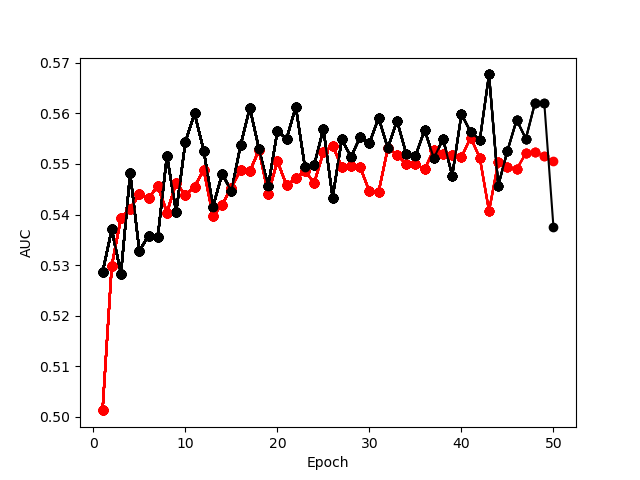


---------
Epoch 1 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 22.030099884416547
Train AUC: 0.5012557816302742
Train Accuracy: 0.5074530949918747



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 3.028376576414467
Validation AUC: 0.528569121679084
Validation Accuracy: 0.49451944753958177
Best Val AUC: 0.528569121679084 at epoch 1
Best Val Loss: 3.028376576414467 at epoch 1
Epoch Time: 4.326532602310181

---------
Epoch 2 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 2.5192202266681205
Train AUC: 0.5298787668621734
Train Accuracy: 0.4892303146698183



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 2.1735796352639074
Validation AUC: 0.5370405391284294
Validation Accuracy: 0.4849317198310487
If converges, will stop in 9 iterations
Best Val AUC: 0.5370405391284294 at epoch 2
Best Val Loss: 2.1735796352639074 at epoch 2
Epoch Time: 4.35282301902771

---------
Epoch 3 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 2.0582544151212967
Train AUC: 0.539301948376464
Train Accuracy: 0.48631260156596245



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.9526989362629135
Validation AUC: 0.5283196877947325
Validation Accuracy: 0.48583866704672074
If converges, will stop in 9 iterations
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.5370405391284294 at epoch 2
Best Val Loss: 1.9526989362629135 at epoch 3
Epoch Time: 4.347790956497192

---------
Epoch 4 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.8568436852185695
Train AUC: 0.5411585418437262
Train Accuracy: 0.4848352784754026



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.7862898672547156
Validation AUC: 0.5481500227970699
Validation Accuracy: 0.48164079707703866
If converges, will stop in 8 iterations
Best Val AUC: 0.5481500227970699 at epoch 4
Best Val Loss: 1.7862898672547156 at epoch 4
Epoch Time: 4.483082056045532

---------
Epoch 5 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.7495322022645898
Train AUC: 0.5440160116146326
Train Accuracy: 0.4819323386024524



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.7095924756111582
Validation AUC: 0.5327853178320467
Validation Accuracy: 0.4914617397838874
If converges, will stop in 9 iterations
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.5481500227970699 at epoch 4
Best Val Loss: 1.7095924756111582 at epoch 5
Epoch Time: 4.337705135345459

---------
Epoch 6 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.6826698834689024
Train AUC: 0.5431837593581146
Train Accuracy: 0.47844585610873097



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.6630991327757598
Validation AUC: 0.5358523258702221
Validation Accuracy: 0.48456894094477987
If converges, will stop in 8 iterations
Best Val AUC: 0.5481500227970699 at epoch 4
Best Val Loss: 1.6630991327757598 at epoch 6
Epoch Time: 4.374602794647217

---------
Epoch 7 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.6496541913997123
Train AUC: 0.5456668485975205
Train Accuracy: 0.4919412025409957



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.6442963467765914
Validation AUC: 0.5355401375982008
Validation Accuracy: 0.501645461377005
If converges, will stop in 9 iterations
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.5481500227970699 at epoch 4
Best Val Loss: 1.6442963467765914 at epoch 7
Epoch Time: 4.32296085357666

---------
Epoch 8 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.6085748271328209
Train AUC: 0.5403881699714745
Train Accuracy: 0.49277589008716205



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5929557089158277
Validation AUC: 0.551663534612431
Validation Accuracy: 0.497447591407323
If converges, will stop in 8 iterations
Best Val AUC: 0.551663534612431 at epoch 8
Best Val Loss: 1.5929557089158277 at epoch 8
Epoch Time: 4.2914934158325195

---------
Epoch 9 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.582172266873321
Train AUC: 0.546249087905852
Train Accuracy: 0.49948293691830403



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5661007244480907
Validation AUC: 0.5404695758642865
Validation Accuracy: 0.46731103106942035
If converges, will stop in 9 iterations
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.551663534612431 at epoch 8
Best Val Loss: 1.5661007244480907 at epoch 9
Epoch Time: 4.314998626708984

---------
Epoch 10 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5587520710999627
Train AUC: 0.543829680564959
Train Accuracy: 0.5022898507903678



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5542560045718095
Validation AUC: 0.5543461752449623
Validation Accuracy: 0.500945816382058
If converges, will stop in 8 iterations
Best Val AUC: 0.5543461752449623 at epoch 10
Best Val Loss: 1.5542560045718095 at epoch 10
Epoch Time: 4.315370082855225

---------
Epoch 11 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5649661520375282
Train AUC: 0.5455438134827117
Train Accuracy: 0.5300487516619885



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5462761964634801
Validation AUC: 0.5600202328180057
Validation Accuracy: 0.5268845067502785
If converges, will stop in 9 iterations
Best Val AUC: 0.5600202328180057 at epoch 11
Best Val Loss: 1.5462761964634801 at epoch 11
Epoch Time: 4.285201549530029

---------
Epoch 12 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5583924503339666
Train AUC: 0.5488187255494659
Train Accuracy: 0.5441276407150244



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5618509794317965
Validation AUC: 0.5526095241744475
Validation Accuracy: 0.5478997693762795
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.5600202328180057 at epoch 11
Best Val Loss: 1.5462761964634801 at epoch 11
Epoch Time: 4.2953269481658936

---------
Epoch 13 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5528410747557349
Train AUC: 0.5397467478177216
Train Accuracy: 0.5417639237701285



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5254788626433118
Validation AUC: 0.5415222504604091
Validation Accuracy: 0.5485216760384546
If converges, will stop in 9 iterations
If performance continues to decrease, will stop in 2 iterations
Best Val AUC: 0.5600202328180057 at epoch 11
Best Val Loss: 1.5254788626433118 at epoch 13
Epoch Time: 4.313374996185303

---------
Epoch 14 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5416566576895903
Train AUC: 0.5419707891942361
Train Accuracy: 0.5565740877529916



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.57124933582537
Validation AUC: 0.5480854658623598
Validation Accuracy: 0.5552589982120183
Best Val AUC: 0.5600202328180057 at epoch 11
Best Val Loss: 1.5254788626433118 at epoch 13
Epoch Time: 4.246925115585327

---------
Epoch 15 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.546723957438632
Train AUC: 0.5452994448584947
Train Accuracy: 0.5695597577190131



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5715448090906252
Validation AUC: 0.5445963528087211
Validation Accuracy: 0.5409551449819906
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.5600202328180057 at epoch 11
Best Val Loss: 1.5254788626433118 at epoch 13
Epoch Time: 4.281890153884888

---------
Epoch 16 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5335745305342752
Train AUC: 0.548817486679774
Train Accuracy: 0.5590855370069434



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5399404305709858
Validation AUC: 0.5537304638020486
Validation Accuracy: 0.5463709154984323
If converges, will stop in 9 iterations
Best Val AUC: 0.5600202328180057 at epoch 11
Best Val Loss: 1.5254788626433118 at epoch 13
Epoch Time: 4.263838291168213

---------
Epoch 17 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5598667015539593
Train AUC: 0.5485243131100666
Train Accuracy: 0.5557394002068252



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5600007024719347
Validation AUC: 0.5610990185955388
Validation Accuracy: 0.5457490088362572
Best Val AUC: 0.5610990185955388 at epoch 17
Best Val Loss: 1.5254788626433118 at epoch 13
Epoch Time: 4.340953588485718

---------
Epoch 18 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.555257693991035
Train AUC: 0.5527701277749588
Train Accuracy: 0.5541217314226622



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5307916124109868
Validation AUC: 0.5530064321573568
Validation Accuracy: 0.5427690394133348
If converges, will stop in 9 iterations
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.5610990185955388 at epoch 17
Best Val Loss: 1.5254788626433118 at epoch 13
Epoch Time: 4.297165155410767

---------
Epoch 19 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.523767293615393
Train AUC: 0.5440611609480274
Train Accuracy: 0.5494386172255873



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5383305009410606
Validation AUC: 0.545545561204738
Validation Accuracy: 0.552408592677049
If performance continues to decrease, will stop in 2 iterations
Best Val AUC: 0.5610990185955388 at epoch 17
Best Val Loss: 1.5254788626433118 at epoch 13
Epoch Time: 4.318366765975952

---------
Epoch 20 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5417875391918414
Train AUC: 0.5505761915629582
Train Accuracy: 0.5603117151721081



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5323391126617887
Validation AUC: 0.5565017382476122
Validation Accuracy: 0.5321966261563577
If converges, will stop in 8 iterations
Best Val AUC: 0.5610990185955388 at epoch 17
Best Val Loss: 1.5254788626433118 at epoch 13
Epoch Time: 4.327743053436279

---------
Epoch 21 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5425148835465308
Train AUC: 0.5457452423365414
Train Accuracy: 0.536548973260452



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5483658090919945
Validation AUC: 0.5549886416360865
Validation Accuracy: 0.5198103184680366
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.5610990185955388 at epoch 17
Best Val Loss: 1.5254788626433118 at epoch 13
Epoch Time: 4.282575845718384

---------
Epoch 22 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5539282334395204
Train AUC: 0.5471704893515932
Train Accuracy: 0.5267690944009454



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.538965030402113
Validation AUC: 0.5613237962114479
Validation Accuracy: 0.5223756834495089
If converges, will stop in 9 iterations
Best Val AUC: 0.5613237962114479 at epoch 22
Best Val Loss: 1.5254788626433118 at epoch 13
Epoch Time: 4.36185884475708

---------
Epoch 23 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5556134763885696
Train AUC: 0.5486259393366612
Train Accuracy: 0.5334835278475403



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.590201851288846
Validation AUC: 0.5493068331107702
Validation Accuracy: 0.5085641729937032
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.5613237962114479 at epoch 22
Best Val Loss: 1.5254788626433118 at epoch 13
Epoch Time: 4.708477973937988

---------
Epoch 24 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5615237083070803
Train AUC: 0.5462346842052587
Train Accuracy: 0.5375757128083912



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.554884332541463
Validation AUC: 0.5497754695905422
Validation Accuracy: 0.5485994143712265
If converges, will stop in 9 iterations
Best Val AUC: 0.5613237962114479 at epoch 22
Best Val Loss: 1.5254788626433118 at epoch 13
Epoch Time: 4.331761360168457

---------
Epoch 25 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5459562504702171
Train AUC: 0.5523454131667862
Train Accuracy: 0.5501920520017728



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5667225884259839
Validation AUC: 0.5569947091124263
Validation Accuracy: 0.5395558549920966
Best Val AUC: 0.5613237962114479 at epoch 22
Best Val Loss: 1.5254788626433118 at epoch 13
Epoch Time: 4.354710817337036

---------
Epoch 26 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5375774036989867
Train AUC: 0.5535482252301951
Train Accuracy: 0.536290441719604



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5243720462162238
Validation AUC: 0.5433623419803575
Validation Accuracy: 0.4731932315824933
If converges, will stop in 9 iterations
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.5613237962114479 at epoch 22
Best Val Loss: 1.5243720462162238 at epoch 26
Epoch Time: 4.327915668487549

---------
Epoch 27 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5258662323846073
Train AUC: 0.5494665797295645
Train Accuracy: 0.5177721967794356



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.537625777310544
Validation AUC: 0.5548435108486809
Validation Accuracy: 0.5336995672566143
Best Val AUC: 0.5613237962114479 at epoch 22
Best Val Loss: 1.5243720462162238 at epoch 26
Epoch Time: 4.339479923248291

---------
Epoch 28 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5276414363667157
Train AUC: 0.5496085996284787
Train Accuracy: 0.5450731274929828



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5277108121288308
Validation AUC: 0.551417216559392
Validation Accuracy: 0.5267290300847348
If converges, will stop in 9 iterations
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.5613237962114479 at epoch 22
Best Val Loss: 1.5243720462162238 at epoch 26
Epoch Time: 4.278538227081299

---------
Epoch 29 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5562686286123792
Train AUC: 0.5493366845578801
Train Accuracy: 0.5304254690500813



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.563289804731344
Validation AUC: 0.5553354903126229
Validation Accuracy: 0.4940271047653598
Best Val AUC: 0.5613237962114479 at epoch 22
Best Val Loss: 1.5243720462162238 at epoch 26
Epoch Time: 4.261162042617798

---------
Epoch 30 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5625375114847373
Train AUC: 0.5445813589662666
Train Accuracy: 0.5191978135618259



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.517395182582087
Validation AUC: 0.5541216293851012
Validation Accuracy: 0.5396335933248685
If converges, will stop in 9 iterations
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.5613237962114479 at epoch 22
Best Val Loss: 1.517395182582087 at epoch 30
Epoch Time: 4.298693418502808

---------
Epoch 31 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.515977515044479
Train AUC: 0.544464614953747
Train Accuracy: 0.5208376421923475



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5087681663076438
Validation AUC: 0.5591203369588734
Validation Accuracy: 0.48889637480241505
If converges, will stop in 8 iterations
Best Val AUC: 0.5613237962114479 at epoch 22
Best Val Loss: 1.5087681663076438 at epoch 31
Epoch Time: 4.371835470199585

---------
Epoch 32 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5231277462136736
Train AUC: 0.5530999437027324
Train Accuracy: 0.5289185994977101



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.561746805622461
Validation AUC: 0.5531462969323379
Validation Accuracy: 0.5048845585758337
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.5613237962114479 at epoch 22
Best Val Loss: 1.5087681663076438 at epoch 31
Epoch Time: 4.33866286277771

---------
Epoch 33 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5368917859831692
Train AUC: 0.5518443440117254
Train Accuracy: 0.5236888757571281



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5079141395475326
Validation AUC: 0.5585485947884039
Validation Accuracy: 0.48975149646290583
If converges, will stop in 9 iterations
Best Val AUC: 0.5613237962114479 at epoch 22
Best Val Loss: 1.5079141395475326 at epoch 33
Epoch Time: 4.310427665710449

---------
Epoch 34 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5034391149555353
Train AUC: 0.5499250824578206
Train Accuracy: 0.5486408627566849



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5250305539968951
Validation AUC: 0.5520214689532645
Validation Accuracy: 0.5193698012489959
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.5613237962114479 at epoch 22
Best Val Loss: 1.5079141395475326 at epoch 33
Epoch Time: 4.355424404144287

---------
Epoch 35 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5362832133434543
Train AUC: 0.5500201651808307
Train Accuracy: 0.52984192642931



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5721669981723052
Validation AUC: 0.5515545191425089
Validation Accuracy: 0.5164934829364359
If performance continues to decrease, will stop in 2 iterations
Best Val AUC: 0.5613237962114479 at epoch 22
Best Val Loss: 1.5079141395475326 at epoch 33
Epoch Time: 4.330246448516846

---------
Epoch 36 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5530504779212249
Train AUC: 0.5489442689021479
Train Accuracy: 0.5323459890678092



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5023744235408163
Validation AUC: 0.5567333526669379
Validation Accuracy: 0.5475369904900106
If converges, will stop in 9 iterations
Best Val AUC: 0.5613237962114479 at epoch 22
Best Val Loss: 1.5023744235408163 at epoch 36
Epoch Time: 4.326541900634766

---------
Epoch 37 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5118331406195824
Train AUC: 0.552850372456813
Train Accuracy: 0.5405599054513222



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.512128506809841
Validation AUC: 0.5511310493414292
Validation Accuracy: 0.5119846596356663
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.5613237962114479 at epoch 22
Best Val Loss: 1.5023744235408163 at epoch 36
Epoch Time: 4.339131832122803

---------
Epoch 38 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5416538591504485
Train AUC: 0.5519369384786313
Train Accuracy: 0.5368961441867336



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5835441195890607
Validation AUC: 0.5549770023323414
Validation Accuracy: 0.5236713223290405
Best Val AUC: 0.5613237962114479 at epoch 22
Best Val Loss: 1.5023744235408163 at epoch 36
Epoch Time: 4.333163022994995

---------
Epoch 39 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.545969022590864
Train AUC: 0.5518236166070091
Train Accuracy: 0.5249741468459153



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.559312372563451
Validation AUC: 0.5476716010619371
Validation Accuracy: 0.5339327822549299
If converges, will stop in 9 iterations
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.5613237962114479 at epoch 22
Best Val Loss: 1.5023744235408163 at epoch 36
Epoch Time: 4.314605236053467

---------
Epoch 40 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5463046908706823
Train AUC: 0.5513516987499001
Train Accuracy: 0.546978874279805



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5633464989232686
Validation AUC: 0.5598816298259528
Validation Accuracy: 0.5200176206887617
Best Val AUC: 0.5613237962114479 at epoch 22
Best Val Loss: 1.5023744235408163 at epoch 36
Epoch Time: 4.381257057189941

---------
Epoch 41 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5680588945980956
Train AUC: 0.5552325148497779
Train Accuracy: 0.5341409366228395



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5558614044920898
Validation AUC: 0.5563118527922665
Validation Accuracy: 0.5066984530071779
If converges, will stop in 9 iterations
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.5613237962114479 at epoch 22
Best Val Loss: 1.5023744235408163 at epoch 36
Epoch Time: 4.312164068222046

---------
Epoch 42 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5413089951587542
Train AUC: 0.5511897033917955
Train Accuracy: 0.49773230905599053



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5294738878715115
Validation AUC: 0.5547682416344177
Validation Accuracy: 0.5177113834831956
If converges, will stop in 8 iterations
If performance continues to decrease, will stop in 2 iterations
Best Val AUC: 0.5613237962114479 at epoch 22
Best Val Loss: 1.5023744235408163 at epoch 36
Epoch Time: 4.368436813354492

---------
Epoch 43 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.535600816889435
Train AUC: 0.5406946861046624
Train Accuracy: 0.483897178312897



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5025223330332473
Validation AUC: 0.567719876876767
Validation Accuracy: 0.4429530201342282
If converges, will stop in 7 iterations
Best Val AUC: 0.567719876876767 at epoch 43
Best Val Loss: 1.5023744235408163 at epoch 36
Epoch Time: 4.340198516845703

---------
Epoch 44 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5175946739567656
Train AUC: 0.5503332290242913
Train Accuracy: 0.48185847244792435



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.51737405012005
Validation AUC: 0.5457076616849932
Validation Accuracy: 0.4815889715218574
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.567719876876767 at epoch 43
Best Val Loss: 1.5023744235408163 at epoch 36
Epoch Time: 4.363012075424194

---------
Epoch 45 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5192828868857615
Train AUC: 0.549447010215791
Train Accuracy: 0.5112793617964249



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5222323310819401
Validation AUC: 0.5526110563394317
Validation Accuracy: 0.5108704101992693
Best Val AUC: 0.567719876876767 at epoch 43
Best Val Loss: 1.5023744235408163 at epoch 36
Epoch Time: 4.368087530136108

---------
Epoch 46 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.494613858473713
Train AUC: 0.5489509154695946
Train Accuracy: 0.5398729502142119



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.4841725134067822
Validation AUC: 0.5587128068237632
Validation Accuracy: 0.5010494674924205
If converges, will stop in 9 iterations
Best Val AUC: 0.567719876876767 at epoch 43
Best Val Loss: 1.4841725134067822 at epoch 46
Epoch Time: 4.460421800613403

---------
Epoch 47 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5022497961112893
Train AUC: 0.5521261132495671
Train Accuracy: 0.49606293396365786



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5227378443648867
Validation AUC: 0.5549869807177423
Validation Accuracy: 0.4746961726827499
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.567719876876767 at epoch 43
Best Val Loss: 1.4841725134067822 at epoch 46
Epoch Time: 4.381211519241333

---------
Epoch 48 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5362937217392938
Train AUC: 0.552393816373548
Train Accuracy: 0.5110060570246713



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5093213534802792
Validation AUC: 0.5621170070364742
Validation Accuracy: 0.5241377523256718
If converges, will stop in 9 iterations
Best Val AUC: 0.567719876876767 at epoch 43
Best Val Loss: 1.4841725134067822 at epoch 46
Epoch Time: 4.3881402015686035

---------
Epoch 49 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5258772956895224
Train AUC: 0.5514907056083501
Train Accuracy: 0.5221302998965874



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5272460042242346
Validation AUC: 0.5621333458378597
Validation Accuracy: 0.48697882926070846
Best Val AUC: 0.567719876876767 at epoch 43
Best Val Loss: 1.4841725134067822 at epoch 46
Epoch Time: 4.4155213832855225

---------
Epoch 50 of 50


  0%|          | 0/529 [00:00<?, ?it/s]

Train Loss: 1.5196408656379543
Train AUC: 0.5505066203008853
Train Accuracy: 0.4960112276554883



  0%|          | 0/38 [00:00<?, ?it/s]

Validation Loss: 1.5178090359329037
Validation AUC: 0.5375343340147476
Validation Accuracy: 0.4853722370500894
If converges, will stop in 9 iterations
If performance continues to decrease, will stop in 3 iterations
Best Val AUC: 0.567719876876767 at epoch 43
Best Val Loss: 1.4841725134067822 at epoch 46
Epoch Time: 4.352656364440918


<IPython.core.display.Javascript object>

/home/monica/anaconda3/envs/myenv/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


   Hidden_Layers  Hidden_Dim  L1_input  L1_hidden  Dropout_input  \
0              1         0.1       0.1    0.00005            0.1   
1              1         0.1       0.1    0.05000            0.1   
2              1         0.1       0.1    0.00500            0.1   

   Dropout_hidden      LR  Best AUC  Best Loss  Best AUC Epoch  \
0             0.4  0.0001  0.562252   1.498086            43.0   
1             0.4  0.0001  0.565465   1.493445            25.0   
2             0.4  0.0001  0.567720   1.484173            43.0   

   Loss at Best AUC Epoch  Best Loss Epoch  AUC at Best Loss Epoch  \
0                1.533301             36.0                0.555605   
1                1.591517             38.0                0.560355   
2                1.502522             46.0                0.558713   

   Total Epochs Status  
0            50   Done  
1            50   Done  
2            50   Done  

---------------
done reading config!


In [14]:
# Read the config file to get experiment values
# TODO change the config file reading pattern
config_file = pd.read_csv(config_filename, sep="\t")

# Read the PRS config file with locations of the PRS2 files
# NOTE: The name of the PRS2 must be the same with the name of the PRS1 files and analyses
# For example, for PRS2 and PRS1 there is a CAD_202 (one is univariate score, the other is individual SNPs)
prs2_config_file = pd.read_csv(prs2_config_filename, sep="\t")

# Read the filenames config file and get the file locations of each relevant file for the disease
disease_data = pd.read_csv(disease_data_filename, sep="\t")

# Read values mapping to get name of the disease
var_mapping_file = pd.read_csv(var_mapping_filename, sep=",")

# Set up GPU or CPU computing
# Note, for usage of GPU, check nvidia-smi
dev = torch.device("cuda:{}".format(gpu_number)) if torch.cuda.is_available() else torch.device("cpu")

# TODO update the dataset class

exp = ExpToRun(config_file, disease_data, var_mapping_file, prs2_config_file, combin_dict=combinations_all,
               exp_number=experiment, prevalent_prs=prevalent_prs, dev=dev, max_epochs=max_epochs)

labels_list = exp.labels_list
disease_label_filename = exp.disease_label_filename


# -- Processing
# Need to pre-process based on the binary classification task for the specific disease of interest
dataset_indices = pd.read_csv(disease_label_filename, sep="\t")[["UKB ID", labels_list[0]]]
# Remove NaNs from the dataset indices
dataset_indices = dataset_indices.iloc[np.where(~dataset_indices[labels_list[0]].isnull())[0]]
dataset_indices.reset_index(inplace=True, drop=True)

print(dataset_indices)

# Get parameters dictionary for samples, and train, validation, and test indices
num_trials = 1
for trial in range(1, num_trials + 1):

    print("\n-----------")
    print("Starting trial {}".format(trial))

    train_idx, valid_idx, test_idx = read_trial_idx(trial, idx_file=exp.indices_filename)

    print("------------\n")

    # Can use this or get values manually
    # Get the penalization values for imbalanced classes
    if penalize_class:
        # Get a dictionary with penalization weights
        penalize_weights = get_penalty_weights(train_idx, labels_list, dataset_indices)

        print("Train Class Penalty: {}\n".format(penalize_weights))

    # AFTER THE INDICES ARE SET, NEXT SET UP MODEL AND DATASET CLASSES UNIQUE TO EACH EXPERIMENT.
    # RUN EACH EXPERIMENT USING THE SAME TRAIN, VALIDATION, AND TEST INDICES
    # ALL OTHER FACTORS CAN BE UNIQUE TO EACH EXPERIMENT.

    # SAVE THE LOSS, AUC, and EPOCH DATA FOR EACH ONE IN TRIAL DIRECTORY

    print("\n---------------")
    print("Running Experiment {}\n".format(experiment))
    exp.wrapper()

    print("\n---------------")

    print("done reading config!")


In [3]:
%matplotlib notebook


In [7]:

class ExpToRun:
    def __init__(self, config_file, disease_data, var_mapping_file, prs2_file, exp_number, combin_dict=None,
                 prevalent_prs=False, dev=None, max_epochs=50):
        """

        :param config_file:
        :param disease_data:
        :param var_mapping_file:
        :param prs2_file:
        :param exp_number:
        :param prevalent_prs: If True, PRS1 and PRS2 will be prevalent prediction instead of incident
        """
        self.exp_number = exp_number
        current_experiment = config_file.loc[config_file["Experiment"] == exp_number, :]

        if current_experiment.empty:
            print("Experiment {} not in the config file.".format(exp_number))
            exit()

        disease = current_experiment["Disease"].item()
        ng_set = current_experiment["NG Features"].item()
        prs_set = current_experiment["PRS Features"].item()
        prs_version = current_experiment["PRS Version"].item()

        # Check if the PRS version is in the list of possible PRSs in the prs2_files_config.txt
        available_prs = list(prs2_file["PRS_Name"]) + ["All", "All_LargeScale"]
        if prs_version not in available_prs:
            print("The PRS Version {} needs to be in the following list: {}\n".format(prs_version,
                                                                                      available_prs))
            exit()

        self.model_type = current_experiment["Model Type"].item()

        # Read values mapping to get name of the disease
        disease_name = var_mapping_file.loc[var_mapping_file["Variable"] == "{}".format(disease), "Meaning"].item()
        print("Disease Name: {}".format(disease_name))

        # Read the filenames config file and get the file locations of each relevant file for the disease
        disease_ng1_filename = disease_data.loc[
            disease_data["Disease"] == disease_name, "NG1_FeatureNames_File"].item()
        self.disease_label_filename = disease_data.loc[
            disease_data["Disease"] == disease_name, "Labels_File"].item()
        disease_sex = disease_data.loc[disease_data["Disease"] == disease_name, "Limit_Sex"].item()

        disease_ng1 = list(pd.read_csv(disease_ng1_filename, sep="\t")["Disease-Specific Risk Factors"])

        if prevalent_prs:
            self.indices_filename = disease_data.loc[disease_data["Disease"] == disease_name, "Samples_Idx_Prevalent"].item()
        else:
            self.indices_filename = disease_data.loc[disease_data["Disease"] == disease_name, "Samples_Idx"].item()

        # TODO this is hardcoded in the script, not the best way, need to add any PRSs
        #  directly to the script or modify to make this clean
        # The names of the PRSs that are >20k features that are only for PRS1
        prs1_largescale_dict = {
            "Myocardial_Infarction": ["CAD_1.7M", "CAD_6M"],
            "Breast_Cancer": ["BC_5k"],
            "Schizophrenia": ["SZ_1M"],
            "Prostate_Cancer": ["PRO_6M"],
            "Pancreatic_Cancer": []
        }

        # If it is All, need to get all PRSs for the disease in prs2_file. This is relevant for PRS1 and PRS2
        if prs_version == "All":
            prs_ver = list(prs2_file.loc[prs2_file["Disease"] == disease_name, "PRS_Name"])
        # TODO check this
        elif prs_version == "All_LargeScale":
            if prs_set == "PRS2":
                print("Does not work for PRS2! Use All instead")
                exit()
            else:
                prs_ver = list(prs2_file.loc[prs2_file["Disease"] == disease_name, "PRS_Name"]) + \
                          prs1_largescale_dict[disease_name]
        else:
            prs_ver = [prs_version]

        # Assumption that the files are derived from setup_vcf.py and compile_prs2.py
        # The assumption is also that the samples data is in the same directory, samples_prs2.txt
        prs2_dict = None
        disease_prs1 = []
        if prs_set == "PRS1":
            disease_prs1 = prs_ver  # A list of one or more PRS names that are in the general data fields file
        if prs_set == "PRS2":
            # Get the location of each PRS file
            prs2_dict = {}
            for prs in prs_ver:
                dir = prs2_file.loc[prs2_file["PRS_Name"] == prs, "Directory"].item()
                gt_filename = "{}/allSNPs_{}.npy".format(dir, prs)
                ids_filename = "{}/allSNPs_{}_ids.txt".format(dir, prs)
                samples_filename = "{}/samples_prs2.txt".format(dir)
                prs2_dict[prs] = {}
                prs2_dict[prs]["data"] = gt_filename  # The filenames with data to load of the genotypes for the PRS
                prs2_dict[prs]["snp_ids"] = ids_filename  # The filenames with SNP ids of the PRSs
                prs2_dict[prs]["samples"] = samples_filename

        print("PRS Set: {}".format(prs_set))
        print("PRS Names: {}".format(prs_ver))
        print("NG Set: {}".format(ng_set))
        print("M: {}".format(self.model_type))
        print("\n-------------------------\n")

        # ---------------
        # PROCESS CONFIG

        if disease_sex == "Female":
            self.sex_subset = True
            self.sex_code = 1
        elif disease_sex == "Male":
            self.sex_subset = True
            self.sex_code = 0
        else:
            self.sex_subset = False
            self.sex_code = "None"

        # If using PRS only, will ignore the incident years
        if ng_set == "None":
            if prevalent_prs:
                self.labels_list = ["all_cases/nan/nan/nan/av1"]
            else:
                self.labels_list = ["time_window_incident/nan/{}.0/nan/av1".format(incident_years)]
        else:
            # Set up the labels list based on the incident years
            self.labels_list = ["time_window_incident/nan/{}.0/nan/av1".format(incident_years)]

        # if (ng_set == "None" and prs2_dict is None) or (ng_set == "None" and disease_prs1 == []):
        #   print("Must have at least one dataset for NG or PRS")
        #  exit()

        # If using disease-specific non-genetic risk factors
        # Access the datafields specific to the disease as datafields_list
        self.datafields_list = []

        if ng_set == "NG1" or ng_set == "NG2":
            self.datafields_list += disease_ng1
        if prs_set == "PRS1":
            self.datafields_list += disease_prs1

        if (ng_set == "NG1" or ng_set == "None") and (prs_set == "PRS1" or prs_set == "None" or prs_set == "PRS2"):
            self.only_datafields = True  # Only read from the general ukb_datafields_v2.h5 file
        else:
            # Relevant for any model with NG2
            self.only_datafields = False  # Do not only read from the general ukb_datafields_v2.h5 file

        self.combinations_dict = combin_dict
        self.max_epochs = max_epochs
            
        self.dev = dev
        self.disease = disease
        self.ng_set = ng_set
        self.prs_set = prs_set
        self.prs2_dict = prs2_dict
        

    def model_dataset_setup(self):
        # To do if using the pre-trained model features
        # Not relevant if only training with basic data fields
        if pretrained_NG2 and not self.only_datafields:
            print("This is not set up, do not use this option for pretrained_NG2")
            exit()

        self.pretrained_model = None
        self.embedding_label_dim = None

        # ------------------------------------------------------------------------------------
        # Set up data loaders and model
        if not self.only_datafields:

            dataset_class = "MedHistory_Dataset"

            if use_embedding:
                medhistory_data = fixed_embedding_data

            self.train_data = dataset_classes.MedHistory_Dataset(train_idx, medhistory_data,
                                                                 medhistory_ids_filename,
                                                                 output_labels=labels_list,
                                                                 class_filename=disease_label_filename,
                                                                 datafields_filename=datafields_filename,
                                                                 datafields_list=self.datafields_list,
                                                                 datafields_idx_filename=datafields_idx_filename,
                                                                 dev=self.dev, prs2_dict=self.prs2_dict
                                                                 )

            self.val_data = dataset_classes.MedHistory_Dataset(valid_idx, medhistory_data, medhistory_ids_filename,
                                                               output_labels=labels_list,
                                                               class_filename=disease_label_filename,
                                                               datafields_filename=datafields_filename,
                                                               datafields_list=self.datafields_list,
                                                               datafields_idx_filename=datafields_idx_filename,
                                                               return_idx=True,
                                                               dev=self.dev, prs2_dict=self.prs2_dict
                                                               )

            self.dataset_initialization_dict = {"Dataset Class": dataset_class, "medhistory_data": medhistory_data,
                                                "medhistory_ids_filename": medhistory_ids_filename, "X_only": False,
                                                "output_labels": labels_list,
                                                "class_filename": disease_label_filename,
                                                "datafields_filename": datafields_filename,
                                                "datafields_list": self.datafields_list,
                                                "datafields_idx_filename": datafields_idx_filename,
                                                "indices_filename": self.indices_filename,
                                                "PRS2_dict": self.prs2_dict}

        # If it is restricted to just using the data fields as input, then use a separate dataset class
        # NOTE: update the dataset class. If prs2_dict != None, then set up prs2 dataset
        else:
            dataset_class = "GeneralDataFields_Dataset"
            self.train_data = dataset_classes.GeneralDataFields_Dataset(train_idx, datafields_filename,
                                                                        datafields_idx_filename,
                                                                        self.datafields_list,
                                                                        output_labels=labels_list,
                                                                        class_filename=disease_label_filename,
                                                                        return_idx=False,
                                                                        prs2_dict=self.prs2_dict,
                                                                        dev=self.dev
                                                                        )

            self.val_data = dataset_classes.GeneralDataFields_Dataset(valid_idx, datafields_filename,
                                                                      datafields_idx_filename,
                                                                      self.datafields_list,
                                                                      output_labels=labels_list,
                                                                      class_filename=disease_label_filename,
                                                                      return_idx=True,
                                                                      prs2_dict=self.prs2_dict,
                                                                      dev=self.dev
                                                                      )
            self.dataset_initialization_dict = {"Dataset Class": dataset_class,
                                                "datafields_filename": datafields_filename,
                                                "datafields_idx_filename": datafields_idx_filename,
                                                "datafields_list": self.datafields_list, "X_only": False,
                                                "output_labels": labels_list,
                                                "class_filename": disease_label_filename,
                                                "indices_filename": self.indices_filename,
                                                "PRS2_dict": self.prs2_dict
                                                }


    def model_setup(self):
        # ------------------------------------------------------------------------------------
        # Set up the combination frame for the model

        # Depends on whether it is M1 or M2 First check which one
        # # If it is M1 (LR), the only parameters to explore will be L1
        # regularization and learning rate. Make sure no regularization is an option regardless. If univariate input,
        # no regularization is the only option.
        # NOTE: the script is not set up for univariate input
        """
        if ng_set == "NG2" and prs_set == "PRS2":
            max_epochs = 500
        if ng_set == "NG2" and prs_set != "PRS2":
            # max_epochs = 100
            max_epochs = 50  # Due to time issues
        if ng_set != "NG2" and prs_set == "PRS2":
            max_epochs = 200
        else:
            max_epochs = 50
        """


        # Check if all current settings are in {"NG1", "PRS1", or "None"}
        # If not, it means PRS2 or NG2 are included
        only_smalldata = np.all([item in {"NG1", "PRS1", "None"} for item in [self.ng_set, self.prs_set]])

        if self.model_type == "M1":
            num_selections = 20
            num_zerol1 = 5  # How many selections with L1 == 0

            # If the dataset comprises only the options in the set {NG1, PRS1, None} then set up no regularization (l1 = 0)
            # with a range of 10 randomly-selected values for learning rate. Then for the remaining 20 selections, change
            # both L1 and LR via random selections
            if only_smalldata:
                l1_first = np.zeros((1, num_zerol1)).flatten()
                # It's okay to have a larger learning rate
                l1_range = loguniform.rvs(0.0001, 0.001, size=num_selections - num_zerol1)
                l1_range = np.concatenate([l1_first, l1_range])
                lr_range = loguniform.rvs(0.0001, 0.001, size=num_selections)
            else:
                # l1_range = loguniform.rvs(0.00001, 0.01, size=num_selections)
                l1_range = loguniform.rvs(0.005, 0.05, size=num_selections)
                # lr_range = loguniform.rvs(0.0001, 0.1, size=num_selections)
                lr_range = loguniform.rvs(1e-5, 1e-3, size=num_selections)

                
            combination_frame = pd.DataFrame({"L1_input": l1_range,
                                              "LR": lr_range,
                                              "Best AUC": [np.nan] * num_selections,
                                              "Best Loss": [np.nan] * num_selections,
                                              "Best AUC Epoch": [np.nan] * num_selections,
                                              "Loss at Best AUC Epoch": [np.nan] * num_selections,
                                              "Best Loss Epoch": [np.nan] * num_selections,
                                              "AUC at Best Loss Epoch": [np.nan] * num_selections,
                                              "Total Epochs": [max_epochs] * num_selections,
                                              "Status": ["Not Started"] * num_selections})

            print(combination_frame)
            

        """
        For M2, do a grid search over
        the main architecture (number of layers and nodes per layer) and then do a random search for L1, L2, LR, and dropout,
        which will be used (the same) for each item in the grid.
        Ex. 2 layers & 0.1*input nodes, 3 layers & 0.1*input nodes, 2 layers & 0.3*input nodes, 3 layers & 0.3*input nodes
        For each one, say we have like 40 random selections for the other parameters, apply it to each item in the grid
        """
        if self.model_type == "M2":
            
            combination_frame = self.combinations_dict
                    # TODO update
        
            
            if combination_frame is None:
                print("Must have a value here")
                print(var)

        self.combination_frame = combination_frame

    def dataloader_and_misc(self):
        # ------------------------------------------------------------------------------------
        # Set up data loader
        self.train_loader = DataLoader(self.train_data, batch_size=train_batch_size, shuffle=True,
                                       num_workers=num_workers)
        self.valid_loader = DataLoader(self.val_data, batch_size=valid_batch_size, shuffle=False,
                                       num_workers=num_workers)

        try:
            self.output_dim = self.train_data.output_dim[0]
        except AttributeError:
            self.output_dim = len(labels_list)

        self.input_dim = self.train_data.input_dim

        if pretrained_NG2 and not self.only_datafields:
            print("This option is not available. Do not use the pretrained_NG2 option.")
            exit()

        if testing_only is False:
            # Set up for saving all trained models here and then removing non-optimal ones
            # Across the combinations
            # The alternative is to save the best model for each combination in directory
            self.saved_models_dir = "{}/saved_models".format(trial_dir)
            subprocess.run(["mkdir", "{}/saved_models".format(trial_dir)], shell=False)
        else:
            self.saved_models_dir = None

    def run_training(self):
        """
        Trains each of the combinations for this experiment
        :return:
        """

        # ------------------------------------------------------------------------------------
        # Set up iterative training for each combination

        best_aucs = []
        best_loss = []
        auc_epoch = []
        total_epochs_list = []
        loss_epoch = []
        loss_atbest_auc_epoch_list = []
        auc_atbestloss_epoch_list = []
        for k in range(len(self.combination_frame)):

            if testing_only is False:
                combination_params_dir = "{}/combination_params".format(trial_dir)
                subprocess.run(["mkdir", "{}/combination_params".format(trial_dir)],
                               shell=False)
                combination_results_dir = "{}/combination_results/combination{}".format(trial_dir, k)
                subprocess.run(["mkdir", "{}/combination_results".format(trial_dir)], shell=False)
                subprocess.run(["mkdir", "{}/combination_results/combination{}".format(trial_dir, k)], shell=False)

            if self.model_type == "M2":
                current_params_dict = {"#hidden_layers": self.combination_frame.loc[k, "Hidden_Layers"],
                                       "input_dim": self.input_dim,
                                       "output_dim": self.output_dim,
                                       "hidden_dim": [round(
                                           self.combination_frame.loc[k, "Hidden_Dim"].item() * self.input_dim)] *
                                                     self.combination_frame.loc[k, "Hidden_Layers"].item(),
                                       "input_regularize_norm": 1,
                                       "output_regularize_norm": "None",
                                       "hidden_regularize_norm": [1] * self.combination_frame.loc[
                                           k, "Hidden_Layers"].item(),
                                       "input_regularize_weight": self.combination_frame.loc[k, "L1_input"].item(),
                                       "output_regularize_weight": 0,
                                       "hidden_regularize_weight": [self.combination_frame.loc[
                                                                        k, "L1_hidden"].item()] *
                                                                   self.combination_frame.loc[
                                                                       k, "Hidden_Layers"].item(),
                                       "input_dropout": self.combination_frame.loc[k, "Dropout_input"].item(),
                                       "output_dropout": 0,
                                       "hidden_dropout": [self.combination_frame.loc[k, "Dropout_hidden"].item()] *
                                                         self.combination_frame.loc[k, "Hidden_Layers"].item(),
                                       "optimizer_lr": self.combination_frame.loc[k, "LR"].item(),
                                       "optimizer_betas": "Default",
                                       "optimizer_eps": "Default",
                                       "optimizer_weightdecay": "Default",
                                       "batch_size": train_batch_size,
                                       "max_epochs": self.max_epochs,
                                       "regression": regression,
                                       "batch_normalize": batch_normalize,
                                       "device": dev,
                                       "elastic_net": elastic_net,
                                       "mse_loss": mse_loss,
                                       "elastic_net_input_lambdas": {
                                           "L1": self.combination_frame.loc[k, "L1_input"].item(),
                                           "L2": 0},
                                       "elastic_net_hidden_lambdas": [{"L1": self.combination_frame.loc[
                                           k, "L1_hidden"].item(),
                                                                       "L2": 0}] * self.combination_frame.loc[
                                                                         k, "Hidden_Layers"].item(),
                                       "penalize_class": penalize_class,
                                       "penalize_weights": penalize_weights,
                                       "multitask": multitask}
            elif self.model_type == "M1":
                current_params_dict = {"#hidden_layers": 0,
                                       "input_dim": self.input_dim,
                                       "output_dim": self.output_dim,
                                       "hidden_dim": [],
                                       "input_regularize_norm": 1,
                                       "output_regularize_norm": "None",
                                       "hidden_regularize_norm": [],
                                       "input_regularize_weight": self.combination_frame.loc[k, "L1_input"].item(),
                                       "output_regularize_weight": 0,
                                       "hidden_regularize_weight": [],
                                       "input_dropout": 0,
                                       "output_dropout": 0,
                                       "hidden_dropout": [],
                                       "optimizer_lr": self.combination_frame.loc[k, "LR"].item(),
                                       "optimizer_betas": "Default",
                                       "optimizer_eps": "Default",
                                       "optimizer_weightdecay": "Default",
                                       "batch_size": train_batch_size,
                                       "max_epochs": self.max_epochs,
                                       "regression": regression,
                                       "batch_normalize": batch_normalize,
                                       "device": dev,
                                       "elastic_net": elastic_net,
                                       "mse_loss": mse_loss,
                                       "elastic_net_input_lambdas": {
                                           "L1": self.combination_frame.loc[k, "L1_input"].item(),
                                           "L2": 0},
                                       "elastic_net_hidden_lambdas": [],
                                       "penalize_class": penalize_class,
                                       "penalize_weights": penalize_weights,
                                       "multitask": multitask}

            if testing_only is False:
                # Save current_params_dict as json file
                with open("{}/combination{}.pkl".format(combination_params_dir, k), "wb") as file:
                    pickle.dump(current_params_dict, file)

                self.combination_frame.loc[k, "Status"] = "In Progress"
                self.combination_frame.to_csv("{}/trial_combinations.txt".format(trial_dir), sep="\t", index=False)

            # TODO while training, save train_auc, train_loss, val_auc, val_loss, epoch_count in combinations_results_dir
            # Train model
            # Set up the model
            print("setting up model...")
            self.ffnn_model = model_classes.FeedForwardNet(current_params_dict).to(dev)
            print("done setting up model...")
            print(self.ffnn_model.named_parameters)
            for param in self.ffnn_model.state_dict():
                print(param, ":", self.ffnn_model.state_dict()[param].size())

            if pretrained_NG2 and not self.only_datafields:
                print("This option is not available. Do not use pretrained_NG2 option")
                exit()

            if testing_only is False:
                results_dir = combination_results_dir
            else:
                results_dir = None
                saved_models_dir = None

            # Train model
            best_valid_auc, best_auc_epoch, best_valid_loss, best_loss_epoch, \
            total_epochs, loss_atbestauc_epoch, \
            auc_atbestloss_epoch = main(self.ffnn_model, self.train_loader, self.valid_loader,
                                                        accum_grads,
                                                        batch_multiples, regression, dev,
                                                        testing_only,
                                                        self.datafields_list,
                                                        encoded_multivariate_label,
                                                        self.pretrained_model,
                                                        self.only_datafields,
                                                        results_dir=results_dir,
                                                        pretrained=pretrained_NG2,
                                                        model_params_dir=self.saved_models_dir,
                                                        combination=k)

            best_aucs += [best_valid_auc]
            best_loss += [best_valid_loss]
            auc_epoch += [best_auc_epoch]
            loss_epoch += [best_loss_epoch]
            loss_atbest_auc_epoch_list += [loss_atbestauc_epoch]
            auc_atbestloss_epoch_list += [auc_atbestloss_epoch]

            total_epochs_list += [total_epochs]  # If it stops early, total_epochs will be less than max_epochs

            self.combination_frame["Best AUC"].iloc[k] = best_valid_auc
            self.combination_frame["Best Loss"].iloc[k] = best_valid_loss
            self.combination_frame["Best AUC Epoch"].iloc[k] = best_auc_epoch
            self.combination_frame["Loss at Best AUC Epoch"].iloc[k] = loss_atbestauc_epoch
            self.combination_frame["Best Loss Epoch"].iloc[k] = best_loss_epoch
            self.combination_frame["AUC at Best Loss Epoch"].iloc[k] = auc_atbestloss_epoch
            self.combination_frame["Total Epochs"].iloc[k] = total_epochs
            self.combination_frame.loc[k, "Status"] = "Done"

            print(self.combination_frame)

            del self.ffnn_model
            gc.collect()
            torch.cuda.empty_cache()

    def wrapper(self):
        """
        Use this to run each of the functions for experiment to get results
        :return:
        """
        self.model_dataset_setup()
        self.model_setup()
        self.dataloader_and_misc()
        self.run_training()

        # Delete the variables to free space on GPUs
        del self.pretrained_model
        del self.train_data, self.val_data
        del self.train_loader, self.valid_loader
        gc.collect()
        torch.cuda.empty_cache()

def read_trial_idx(trial_num, idx_file):
    """
    Reads the train, validation, and test indices for each trial
    The idx_file is the file name
    :return: train_idx, valid_idx, test_idx
    """

    idx_file = np.load(idx_file)

    train_idx = idx_file["train_trial{}".format(trial_num)]
    valid_idx = idx_file["valid_trial{}".format(trial_num)]
    test_idx = idx_file["test_trial{}".format(trial_num)]

    return train_idx, valid_idx, test_idx


In [8]:

def main(model, train_loader, valid_loader, accum_grads, batch_multiples, regression, dev, testing_only,
         datafields_list, encode_multivariate_label, pretrained_model, only_datafields, results_dir=None,
         multitask=False,
         pretrained=False, model_params_dir=None, combination=None):
    # Run the model

    # TODO update if needed
    """
    # Get and save the model weights at layer 1 before training
    for name, params in model.named_parameters():
        if name == "layers_list.0.weight":
            np.save("first_input_weights.npy", params.cpu().detach().numpy())
    """

    # Write a file that the script checks after each epoch which says whether or not to move on to next parameter set
    # TODO set this up
    import time

    start_all_time = time.time()

    fig, ax = plt.subplots(1,1)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("AUC")
    
    tol = 1e-4
    n_iter_no_change = 10  # Number of consecutive epochs change in validation loss <= tol
    n_iter_worse_results = 4  # Number of consecutive epochs change in validation AUC is negative

    train_loss = []
    valid_loss = []
    epoch_count = []
    valid_reg_loss = []  # Regularization loss term
    valid_main_loss = []  # BCE or MSE loss term
    train_reg_loss = []
    train_main_loss = []
    count = 0  # Keep track of changes in loss for each batch of samples across the different epochs
    loss_list = []  # Keep track of loss after each batch of samples across the different epochs
    samples_list = []  # Keep track of the total number of samples
    train_auc = []  # Only if regression is False
    valid_auc = []  # Only if regression is False
    best_val_loss = None  # Initialize this
    no_change_epochs = 0  # This variable counts the consecutive epochs with loss diff < tol
    worse_results_epochs = 0  # This variable counts the consecutive epochs with negative AUC diff
    for epoch in range(model.max_epochs):
        print("\n---------\nEpoch {} of {}".format(epoch + 1, model.max_epochs))
        start_epoch_time = time.time()

        # Run the train function
        train_epoch_loss, train_epoch_auc, train_epoch_accuracy, train_loss_breakdown = fit_model_accum(model,
                                                                                                        train_loader,
                                                                                                        dev)

        print("Train Loss: {}\nTrain AUC: {}\nTrain Accuracy: {}\n".format(train_epoch_loss,
                                                                           train_epoch_auc,
                                                                           train_epoch_accuracy))

        # Validate Model
        # NOTE: Returns last_layer_preactivation for percentile vs. prevalence plot
        # Combined input model
        val_epoch_loss, val_epoch_auc, \
        val_epoch_accuracy, last_layer_preactivation, valid_loss_breakdown = validate_model_addfields_copy(
            model, valid_loader, dev, report_results=False)


        print("Validation Loss: {}\nValidation AUC: {}\nValidation Accuracy: {}".format(val_epoch_loss,
                                                                                        val_epoch_auc,
                                                                                        val_epoch_accuracy))

        # Check for convergence and early stopping based on loss function
        if epoch >= 1:
            prev_epoch_auc = valid_auc[-1]
            prev_epoch_loss = valid_loss[-1]
            if (val_epoch_loss - prev_epoch_loss) < tol:
                no_change_epochs += 1
                print("If converges, will stop in {} iterations".format(
                    n_iter_no_change - no_change_epochs))
            if (val_epoch_auc - prev_epoch_auc) < 0:
                worse_results_epochs += 1
                print("If performance continues to decrease, will stop in {} iterations".format(
                    n_iter_worse_results - worse_results_epochs
                ))

            else:
                no_change_epochs = 0
                worse_results_epochs = 0

        train_loss.append(train_epoch_loss)
        valid_loss.append(val_epoch_loss)
        epoch_count.append(epoch + 1)

        
        # TODO add this

        # Save the breakdown of how regularization vs. MSE / BCE loss change
        train_main_loss.append(train_loss_breakdown["Main Loss"])
        train_reg_loss.append(train_loss_breakdown["Reg Loss"])
        valid_main_loss.append(valid_loss_breakdown["Main Loss"])
        valid_reg_loss.append(valid_loss_breakdown["Reg Loss"])

        if not regression:
            train_auc.append(train_epoch_auc)
            valid_auc.append(val_epoch_auc)

            best_val_auc = np.max(valid_auc)
            auc_epoch = np.argmax(valid_auc)
            print("Best Val AUC: {} at epoch {}".format(best_val_auc, auc_epoch + 1))

        best_val_loss = np.min(valid_loss)
        print("Best Val Loss: {} at epoch {}".format(best_val_loss, np.argmin(valid_loss) + 1))

        # ------------------------------------------------------------------------------------
        # How to stop early
        
        ax.plot(epoch_count, train_auc, "-or", label="Train")
        ax.plot(epoch_count, valid_auc, "-ok", label="Val")
        fig.canvas.draw()
        
        # Stop early if there has been almost no change in loss over many epochs
        if no_change_epochs > n_iter_no_change:
            stopearly = True
        if worse_results_epochs > n_iter_worse_results:
            stopearly = True
        else:
            stopearly = False

        if stopearly:
            best_val_loss = np.min(valid_loss)
            loss_epoch = np.argmin(valid_loss)
            loss_atbestauc_epoch = valid_loss[auc_epoch]
            auc_atbestloss_epoch = valid_auc[loss_epoch]
            
            if not regression:
                # TODO the experiment 1 trial 1 training had it without auc_epoch+1 or loss_epoch+1
                #  Make it consistent for all of them; either remove before running another trial
                #  or keep the +1 and know that experiment 1 trial 1 is different
                del model
                gc.collect()
                torch.cuda.empty_cache()
                return best_val_auc, auc_epoch + 1, best_val_loss, loss_epoch + 1, epoch + 1, loss_atbestauc_epoch, \
                       auc_atbestloss_epoch
            else:

                return best_val_loss, loss_epoch + 1, epoch + 1

        print("Epoch Time: {}".format(time.time() - start_epoch_time))
        # print("Overall Time: {}".format(time.time() - start_all_time))
        # print("Estimated Time Left {}".format((model.max_epochs - epoch) * (time.time() - start_epoch_time)))

    best_val_loss = np.min(valid_loss)
    loss_epoch = np.argmin(valid_loss)
    
    if not regression:
        best_val_auc = np.max(valid_auc)
        best_val_loss = np.min(valid_loss)
        auc_epoch = np.argmax(valid_auc)
        loss_atbestauc_epoch = valid_loss[auc_epoch]
        auc_atbestloss_epoch = valid_auc[loss_epoch]
        # TODO the experiment 1 trial 1 training had it without auc_epoch+1 or loss_epoch+1
        #  Make it consistent for all of them
        del model
        gc.collect()
        torch.cuda.empty_cache()
        return best_val_auc, auc_epoch + 1, best_val_loss, loss_epoch + 1, epoch + 1, loss_atbestauc_epoch, auc_atbestloss_epoch

    else:
        del model
        gc.collect()
        torch.cuda.empty_cache()
        return best_val_loss, loss_epoch + 1, epoch + 1


In [9]:

def remove_bad_epochs(val_auc, outputs_dir, filename_stem, valid_loss):
    """
    Remove the saved trained model that does not have the lowest valid loss or best performance, to save space.
    :param valid_loss: Validation loss vector
    :param outputs_dir: Directory where model state is saved
    :param filename_stem: The stem of the file name
    Assumption: The file name format will be "{}_epoch{}.pt".format(filename_stem, epoch)
    Where the epoch filename numbers start from 1, not 0
    Requires valid_loss, outputs_dir to be defined in the main script
    """
    # Find the best epoch
    best_auc_epoch = np.argmax(val_auc) + 1
    best_loss_epoch = np.argmin(valid_loss) + 1
    # Show all files in the directory in a list
    output_dir_files = os.listdir(outputs_dir)
    model_filenames_todelete = []
    for filename in output_dir_files:
        if filename.startswith("{}_epoch".format(filename_stem)):
            model_filenames_todelete += [filename]
    # Remove the best epoch filename from the list of files to delete
    model_filenames_todelete.remove("{}_epoch{}.pt".format(filename_stem, best_auc_epoch))
    best_auc_model_filename = "{}/{}_epoch{}.pt".format(outputs_dir, filename_stem, best_auc_epoch)

    if best_auc_epoch != best_loss_epoch:
        model_filenames_todelete.remove("{}_epoch{}.pt".format(filename_stem, best_loss_epoch))
        best_loss_model_filename = "{}/{}_epoch{}.pt".format(outputs_dir, filename_stem, best_loss_epoch)
    else:
        best_loss_model_filename = best_auc_model_filename

    # Delete remaining files that are not from the best epoch
    for filename in model_filenames_todelete:
        subprocess.run(["rm",
                        "{}/{}".format(outputs_dir, filename)], shell=False)
    return best_auc_model_filename, best_loss_model_filename


def classification_metrics(y_true, y_pred):
    # Get AUC

    fpr, tpr, _ = roc_curve(np.vstack(y_true), np.vstack(y_pred))
    roc_auc = auc(fpr, tpr)

    np.save("fpr.npy", fpr)
    np.save("tpr.npy", tpr)

    # Get Accuracy
    accuracy = accuracy_score(np.vstack(y_true), np.round(np.vstack(y_pred)))

    return roc_auc, accuracy


def fit_model_accum(input_model, dataloader, dev):
    input_model.train()
    running_loss = 0
    running_main_loss = 0
    running_reg_loss = 0
    y_true = []  # A list of np arrays containing true labels for each batch
    y_pred = []  # A list of np arrays containing predicted labels for each batch
    last_layer = []
    for i, (X_batch, y_batch) in tqdm(enumerate(dataloader), total=len(dataloader)):
        X_batch = Variable(X_batch.view(-1, input_model.input_dim)).float().to(dev)
        y_batch = y_batch.float().to(dev)

        input_model.optimizer.zero_grad()

        y_trained, last_layer_preactivation = input_model.forward(X_batch)  # Forward propagation

        # NOTE: last_layer_preactivation is the output layer before activation functions
        # For classification, it is before sigmoid, for regression it is before ReLU or same as output
        # Encode the true label (the default label provided is not encoded)

        # Get the loss and save y_batch (true label) and y_trained (learned label) in list of numpy arrays
        loss, main_loss = input_model.get_loss(y_trained, y_batch)

        # Save the y_true and y_pred
        y_true += list(y_batch.cpu().detach().numpy())
        y_pred += list(y_trained.cpu().detach().numpy())

        # Save the running loss
        running_loss += loss.item()
        running_main_loss += main_loss  # Main loss (BCE or MSE)
        running_reg_loss += loss.item() - main_loss  # Regularization loss

        last_layer += list(last_layer_preactivation.cpu().detach().numpy())

        del X_batch, y_batch

        # Get derivative of the loss dloss/dx with respect to every parameter x which has requires_grad=True
        # The gradients are accumulated into x.grad for each parameter x
        # This basically provides the partial derivative of the loss with respect to each parameter in mode
        # Backpropagation
        loss.backward()
        input_model.optimizer.step()

    loss = running_loss / len(dataloader)  # The average loss for the epoch
    main_loss = running_main_loss / len(dataloader)  # The main loss term
    reg_loss = running_reg_loss / len(dataloader)  # The regularization loss term

    loss_breakdown = {"Main Loss": main_loss, "Reg Loss": reg_loss}

    # Get classification metrics
    roc_auc, accuracy = classification_metrics(y_true, y_pred)

    gc.collect()
    torch.cuda.empty_cache()

    return loss, roc_auc, accuracy, loss_breakdown


# Include the data fields added later for both pre-trained and original models
# The models should have been set up with the correct input dimensions
def validate_model_addfields_copy(trained_model, dataloader, dev, report_results=False):
    trained_model.eval()
    running_loss = 0  # Sum the loss for each different epoch
    running_main_loss = 0
    running_reg_loss = 0
    y_true = []  # A list of np arrays containing true labels for each batch
    y_pred = []  # A list of np arrays containing predicted labels for each batch
    last_layer = []  # A list of np arrays containing the last layer before activation function
    ukb_ids = []  # A list of np arrays containing UKB IDs for the samples
    with torch.no_grad():  # This does not accumulate the gradients for the parameters
        for i, (X_batch, y_batch, X_idx) in tqdm(enumerate(dataloader), total=len(dataloader)):

            X_batch = Variable(X_batch.view(-1, trained_model.input_dim)).float().to(dev)

            y_batch = y_batch.reshape(-1, 1).float().to(dev)

            # The same dimension as y
            y_trained, last_layer_preactivation = trained_model.forward(X_batch)
            # NOTE: last_layer_preactivation is the output layer before activation functions
            # For classification, it is before sigmoid, for regression it is before ReLU or same as output
            # For classification this can be used for percentile vs. prevalence plot

            # Get loss and save y_batch (true label) and y_trained (learned label) in list of numpy arrays
            loss, main_loss = trained_model.get_loss(y_trained, y_batch)

            # Save the y_true and y_pred
            y_true += list(y_batch.cpu().detach().numpy())
            y_pred += list(y_trained.cpu().detach().numpy())

            last_layer += list(last_layer_preactivation.cpu().detach().numpy())

            if report_results:
                # Save the UKB IDs
                ukb_ids += list(X_idx.cpu().detach().numpy())

            running_loss += loss.item()
            running_main_loss += main_loss
            running_reg_loss += loss.item() - main_loss

            del X_batch, y_batch

    validation_loss = running_loss / len(dataloader)  # Total loss
    main_loss = running_main_loss / len(dataloader)  # Main loss (BCE or MSE)
    reg_loss = running_reg_loss / len(dataloader)  # Regularization loss

    # Loss breakdown between main loss (BCE or MSE) and regularization loss
    loss_breakdown = {"Main Loss": main_loss, "Reg Loss": reg_loss}

    # Get classification metrics
    roc_auc, accuracy = classification_metrics(y_true, y_pred)
    # The error is this one: "ValueError: Input contains NaN, infinity or a value too large for dtype('float32')"

    if report_results:  # Provide more data on the validation run
        # Stack the UKB IDs as an array
        ukb_ids = np.array(ukb_ids)
        raw_data = {"y_true": y_true,
                    "y_pred": y_pred,
                    "UKB IDs": ukb_ids}
        return validation_loss, roc_auc, accuracy, last_layer, loss_breakdown, raw_data

    gc.collect()
    torch.cuda.empty_cache()
    # np.save("epoch{}_y_true_val.npy".format(epoch), y_true)

    return validation_loss, roc_auc, accuracy, last_layer, loss_breakdown
